# Weight tracking, analysis and forecast

## Setup

In [1]:
import numpy as np
import csv
import datetime
from datetime import date
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
import os
import sys
import pandas as pd
import seaborn as sns
import tensorflow as tf

from zipfile import ZipFile

In [2]:
print(f'Python = {sys.version}')
print(f'Numpy = {np.__version__}')
print(f'Tensorflow = {tf.__version__}')

Python = 3.8.11 (default, Aug  6 2021, 09:57:55) [MSC v.1916 64 bit (AMD64)]
Numpy = 1.20.3
Tensorflow = 2.5.0


# Data Extraction

=> file "data_BEN.zip" contains the file "weight.csv" with all daily measurements of total mass, fat mass.

=> file "Suivi_Poids.csv" has manually-entered daily numbers for total mass and fat mass, plus nutrition data (lipid, carbs, proteines), and calories data (ingested, spent with cardio, spent with strength training)

In [3]:
ROOT = os.getcwd() + '/'
print(f'current working directory is {ROOT}')
print(f'contains :')
print(f'{os.listdir(ROOT)}')

current working directory is c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/
contains :
['.git', '.ipynb_checkpoints', 'data_BEN.zip', 'desktop.ini', 'model.png', 'pat.txt', 'README.md', 'Suivi_Poids.csv', 'test_methodes.xlsx', 'tmp', 'weight.ipynb', 'weight_arima.ipynb']


In [4]:
class GetData():
    
    """
    Basic class to to all the data extraction work :
    - extracts the two files
    - replaces manually entered numbers for total mass and fat mass by calculated averages if available
    - provides method to export processed data
    """
    
    def __init__(self, zip_file_name, manual_file_name):
        self.zip_file_name = zip_file_name
        self.manual_follow_up_file_name = manual_file_name
        self.daily_mass_measurements = []
        self.daily_data = []
    
    def extract(self):
        # extract data from the two files
        # first : data_BEN.zip
        
        root = os.getcwd() + '/'
        weight_file_path = root + 'tmp'

        with ZipFile(self.zip_file_name, 'r') as fichier_zip:
            print(f'Extraction fichier Zip Healthmate dans {weight_file_path}...')
            fichier_zip.extractall(path = weight_file_path)
            print(f'... Done')
        
        weight_file_csv_name = weight_file_path + '/weight.csv'
        fields = ['date', 
                  'MT', 
                  'MG']

        self.raw_from_zip = self.__extract_data(weight_file_csv_name, 
                                                fields,
                                                skip=1, 
                                                delimiter=',')  # gets a list of dictionnaries
        
        # 1/ self.raw_from_zip is a list of dictionnaries, that's the set of all mass measurements from Withings scale
        # there can be several measurements per day (and there usually are)
        
        # format is :
        # [ { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        #   ....,
        #   { 'date' : 'YYYY-MM-DD time', 'MT' : str of total mass, 'MG' : str of fat mass, None : ['','','']},
        # ]
                
        # second : Suivi_Poids.csv
        
        fields = ['date', 
                  'Masse Totale', 
                  'Masse Grasse', 
                  'Calories in', 
                  'Glucides', 'Lipides', 'Proteines', 
                  'Calories Exercice Brut', 'C_Ex_Cardio', 'C_Ex_Strength',
                  'Verif']
        
        self.raw_from_manual = self.__extract_data(self.manual_follow_up_file_name, 
                                                   fields,
                                                   skip=2, 
                                                   delimiter=';')  # returns and stores a list of disctionnaries
              
        
        # 2/ self.raw_from_manual is a list of dictionnaries, with one set of data per day, from a *.csv follow-up file
        
        # format is :
        # [ { 'date' : 'DD-month_name-YYYY', 'Masse Totale' : str of total mass, 'Masse Grasse' : str of fat mass,
        #     'Calories In' : str of kcals, 'Glucides' : str, 'Lipides' : str, 'Proteines' : str, 'Calories Exercice Brut': str,
        #     'C_Ex_Cardio': str, 'C_Ex_Strength': str, 'Verif': str, None: ['', '']
        #   },
        # ....
        # ]
        
        # ------------------------------
        # -- data consolidation --------
        # ------------------------------
        
        # 1/ creates an attribute self.daily_mass_measurements, which is a list of dictionnaries, containing all the mass measurements
        # per day, non empty, in float format - created from self.raw_from_zip
        
        # format is :
        
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        for cdict in self.raw_from_zip:
            cdate = self.__conv_to_date_num(cdict.get('date'))
            cmt = self.__conv_to_float(cdict.get('MT'))
            cmg = self.__conv_to_float(cdict.get('MG'))
            self.__add_daily_mass_measurement(cdate, cmt, cmg)
            
        # 2/ creates an attribute self.daily_data, which is a list of dictionnaries, containing all the measurements of the day
        # plus the calories data from the *.csv file (self.raw_from_manual)
        # if available in self.daily_mass_measurements, then the mass data in self.daily_data is overwritten by the averages
        # in self.daily_mass_measurements
        
        # format is :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        for cdict in self.raw_from_manual:
            cdate = self.__conv_to_date_str(cdict.get('date'))
            found, cmt, cmg = self.get_daily_mass_measurement(cdate)  # is the mass data in the Withings file ?
            if found:
                cmt = np.mean(cmt)
                cmg = np.mean(cmg)
            else:
                cmt = self.__conv_to_float(cdict.get('Masse Totale'))
                cmg = self.__conv_to_float(cdict.get('Masse Grasse'))
            cals_in = self.__conv_to_float(cdict.get('Calories in', '0.0'))
            glu = self.__conv_to_float(cdict.get('Glucides', '0.0'))
            lip = self.__conv_to_float(cdict.get('Lipides','0.0'))
            prot = self.__conv_to_float(cdict.get('Proteines', '0.0'))
            cals_ex = self.__conv_to_float(cdict.get('Calories Exercice Brut', '0.0'))
            cals_card = self.__conv_to_float(cdict.get('C_Ex_Cardio', '0.0'))
            cals_str = self.__conv_to_float(cdict.get('C_Ex_Strength', '0.0'))
            new_rec = dict([ ('date', cdate), 
                             ('masse_totale', cmt),
                             ('masse_grasse', cmg),
                             ('calories_in', cals_in),
                             ('glucides', glu),
                             ('lipides', lip),
                             ('proteines', prot),
                             ('calories_exercice', cals_ex),
                             ('calories_cardio', cals_card),
                             ('calories_strength', cals_str)
                             ])
            self.daily_data.append(new_rec)            
                    
    def __add_daily_mass_measurement(self, cdate : datetime.datetime, cmt : float, cmg : float):
        # utility : add cmt, cmg to the self.daily_mass_measurements records, or create it if first time
        found = False
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                self.daily_mass_measurements[i]['mt'].append(cmt)
                self.daily_mass_measurements[i]['mg'].append(cmg)
        if not found:
            new_rec = dict([ ('date', cdate), ('mt', [cmt]) , ('mg', [cmg]) ])
            self.daily_mass_measurements.append(new_rec)
            
    def get_daily_mass_measurement(self, cdate : datetime.datetime):
        # access to list of daily mass measurements
        # returns :
        # (True, list of mt measurements, list of mg measurements) if exist
        # (False, 0.0, 0.0) if does not exist
        found = False
        daily_mt = 0.0
        daily_mg = 0.0
        
        for i, daily_m_dict in enumerate(self.daily_mass_measurements):
            if daily_m_dict.get('date') == cdate:
                found = True
                daily_mt = daily_m_dict.get('mt')
                daily_mg = daily_m_dict.get('mg')
                
        return found, daily_mt, daily_mg
    
    def get_window_daily_mass_measurements(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of daily_mass_measurements between the two dates
        # format is, for the relevant dates :
        # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
        #     'mg' : list of total mass measurements of the day (floats) },
        #   ...
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, daily_mt, daily_mg = self.get_daily_mass_measurement(cdate)
            if found:
                window.append( dict([ ('date',cdate), ('mt',daily_mt), ('mg', daily_mg) ]) )
                
        return window
    
    def get_daily_data(self, cdate : datetime.datetime):
        # access to list of daily data
        
        # returns :
        # (True, dict of dialy data if exist
        # (False, {}) if does not exist
        found = False
        ret_dict = {}
        
        for i, daily_m_dict in enumerate(self.daily_data):
            if daily_m_dict.get('date') == cdate:
                found = True
                ret_dict = self.daily_data[i]
                
        return found, ret_dict
    
    def get_window_daily_data(self, start_date : datetime.datetime, end_date : datetime.datetime):
        # return a list of dictionnaries, being the extract of the daily data between the two dates
        # format is, for the relevant dates :
        
        # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
        #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
        #     'calories_cardio': float, 'calories_strength': float },
        # ....
        # ]
        
        if start_date >= end_date:
            raise NameError('Requesting window with start date posterior to end date')
        
        duration = (end_date - start_date).days
        dates_list = [ start_date + datetime.timedelta(days = d) for d in range(duration) ]
        window = []
        
        for cdate in dates_list:
            found, cdict = self.get_daily_data(cdate)
            if found:
                window.append( cdict )
                
        return window
    
    def __extract_data(self,
                       filename, 
                       champs,
                       skip=2,
                       delimiter=','):
        """
        Helper function that reads a csv file, returns a list of dictionnaries
        Each dict is a line, ie a daily measurement, in the file.
        Skips the first line(s)
        
        Parameters :
        filename (str) : name of the *.csv file
        fieldnames (sequence) : sequence of the columns names
        skip (int) : number of lines to skip at the beginning of the file
        delimiter (str) : character used as a delimiter
        """

        data = []
        with open(filename, newline='') as csvfile:
            fichier = csv.DictReader(csvfile, fieldnames=champs, delimiter=delimiter)
            for i in range(skip):  # skip <skip> lines at the beginning of the file
                next(fichier)
            for row in fichier:
                data.append(row)

        return data
    
    def __conv_to_date_str(self, date_string : str) -> datetime.date:
        """
        helper function that converts string outputs of dates, 
        with format "YY-month_name-day", and returns a date object
        from datetime.
        """

        dict_mois = {'août' : 8, 
                     'sept.' : 9,
                     'oct.' : 10,
                     'nov.' : 11,
                     'déc.' : 12,
                     'janv.' : 1,
                     'févr.' : 2,
                     'mars' : 3,
                     'avr.' : 4,
                     'mai' : 5,
                     'juin' : 6,
                     'juil.' : 7
                    }
        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = 2000 + int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            try:
                month = dict_mois.get(d[1])
            except ValueError:
                raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_date_num(self, date_string : str) -> datetime.date:
        """
        helper function that converts a "YYYY-MM-DD" string into a date object
        """

        d = date_string.split(' ')[0]  # récupère la date en début de string : 2xxx-MM-DD
        d = d.split('-')  # récupère year, month, day

        # print(d)

        try:
            day = int(d[2])
        except ValueError:
            raise NameError('problème de format dans un champ date (jour)')

        try:
            year = int(d[0])
        except ValueError:
            raise NameError('problème de format dans un champ date (année)')

        try:
            month = int(d[1])
        except ValueError:
            raise NameError('problème de format dans un champ date (mois)')

        date_object = datetime.date(year, month, day)

        return date_object
    
    def __conv_to_float(self, float_string:str) -> float:
        """
        conversion basique+ en float.

        renvoie 0 si string vide ou remplie d'espaces, ou string = '-'.
        """

        if type(float_string) is None:
            return 0

        float_string = float_string.replace(" ","")
        if not float_string:
            return 0
        if float_string == "-":
            return 0

        try:
            float_string = float_string.replace(" ","")
            valeur = float(float_string.replace(',','.'))
        except ValueError:
            raise NameError('une tentative de conversion en float a échouée car string non compatible')

        return valeur

In [5]:
ds = GetData(ROOT + 'data_BEN.zip', ROOT + 'Suivi_Poids.csv')

In [6]:
ds.extract()

Extraction fichier Zip Healthmate dans c:\Users\benjamin.deporte\Documents\095_Code_Python_Toy\Weight/tmp...
... Done


# Basic display of data

We want :
- display of total mass over time, along with average over n days, and regression over m days
- idem for fat mass, body fat percentage
- display of calories, calories exercices, net cals, etc over time, along with average over n days

In [7]:
class Display():
    """
    class to provide graphical output based on data passed as a parameter
    """
    
    def __init__(self, window_daily_mass_measurements, window_daily_data):
        """Constructor. Uses the formats viewed  in the GetData class

        Args:
        
            window_daily_mass_measurements ([type]): 
            
                # format is :
                # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   ...
                # ]
                
            window_daily_data ([type]): [description]
            
                # format is :
                # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
                #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
                #     'calories_cardio': float, 'calories_strength': float },
                # ....
                # ]    
                
        """
        
        self.daily_mass_measurements = window_daily_mass_measurements
        self.daily_data = window_daily_data   
    
    def __basic_plot(self,
                     data_list, 
                     grid=True,
                     title='titre', perc=False,
                     rolling_average=False, n_avg=7, 
                     linear_regression=False, n_reg=30):
        
        """Private method for basic display of one data over time, along with rolling average and linear regression
        
        Parameters :
        ------------
        data_list (list of dictionnaries) : this is the data, format is [ { 'date' : datetime.date object, 'y' : float} ...]
        grid (bool, optional): [présence ou pas de la grille]. Defaults to True.
        title(string, optional): [titre]. Defaults to 'titre'
        rolling_average (bool, optional): [affiche ou pas la moyenne glissante]. Defaults to False.
        n_avg (int, optional): [fenêtre de calcul de la moyenne glissante]. Defaults to 7.
        linear_regression (bool, optional): [affiche ou pas la régression linéaire]. Defaults to False.
        n_reg (int, optional): [fenêtre de calcul de la régression linéaire]. Defaults to 30.

        Returns:
        --------
            [type]: [description]
        """
        
        X = [ cdict.get('date') for cdict in data_list ]
        y = [ cdict.get('y') for cdict in data_list ]
        
        if rolling_average or linear_regression:
            fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(24,8))
        else:
            fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8,8))
            
        ax1.plot(X, y, color='blue', marker='x')
        ax1.set_title(title)
    
        if grid: 
            ax1.grid()
            
        # calcule le rolling average sur n_avg jours
        moy = np.zeros(shape=len(y))
        moy[0] = y[0]
        for i in range(1,len(y)):
            id = max(0, i-n_avg+1)
            moy[i] = np.mean(y[id:i])
    
        if rolling_average:
            # plot moyenne glissante sur les n_moy dernières valeurs
            ax1.plot(X, moy, color='red', marker='o')
            ax2.text(0.1,0.9,f'moyenne glissante sur {n_avg} jours')
    
        if linear_regression:
            # plot regression linéaire sur les n_reg dernières valeurs des valeurs rolling average
            X_num = np.array([ d.toordinal() for d in X]).reshape(-1,1)
            lr_model = LinearRegression().fit(X_num[-n_reg:], moy[-n_reg:])   # fit sur les n_reg dernières valeurs du rolling average
            reg_pred = lr_model.predict(X_num)
            ax1.plot(X, reg_pred, color='green', marker='+')
            pente =lr_model.coef_[0] * 30 # coefficient par mois
            if perc==True: pente *= 100
            coeff = lr_model.score(X_num[-n_reg:], moy[-n_reg:])
            ax2.text(0.1,0.8,f'régression calculée sur {n_reg} jours (de {X[-n_reg]} à {X[-1]}) sur les valeurs moyennées {n_avg} jours')
            if perc==True:
                str_pente = f'pente = {np.around(pente, decimals=3)}% / mois'
            else:
                str_pente = f'pente = {np.around(pente, decimals=3)} / mois'
            ax2.text(0.1,0.7,str_pente)
            ax2.text(0.1,0.6,f'coefficient régression = {np.around(coeff * 100,1)}%')
        
        return fig
    
    def plot_weight(self, **kwargs):
        """plot the total mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mt'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='total mass', 
                          **kwargs)
        
    def plot_fat(self, **kwargs):
        """plot the fat mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mg'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='Fat mass', 
                          **kwargs)
        
    def plot_lean_mass(self, **kwargs):
        """plot the lean mass data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mt')) - np.mean(cdict.get('mg'))) ] ) for cdict in self.daily_mass_measurements ]
        self.__basic_plot(data_list, 
                          title='Lean mass', 
                          **kwargs)
        
    def plot_body_fat_percentage(self, **kwargs):
        """plot the body fat percentage data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('mg')) / np.mean(cdict.get('mt')) ) ] ) for cdict in self.daily_mass_measurements if np.mean(cdict.get('mt'))>0 ]
        self.__basic_plot(data_list, 
                          title='body fat percentage', 
                          perc=True,
                          **kwargs)
        
    def plot_calories_net(self, **kwargs):
        """plot the net calories data
        """
        
        data_list = [ dict( [ ('date', cdict.get('date')), ('y', np.mean(cdict.get('calories_in')) - np.mean(cdict.get('calories_exercice'))) ] ) for cdict in self.daily_data ]
        self.__basic_plot(data_list, 
                          title='net calories', 
                          **kwargs)

# Plot de toutes les données depuis 2020

In [8]:
window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date(2020,9,1), end_date = datetime.date.today() )

graph = Display(window_daily_mass_measurements, window_daily_data)

In [9]:
n_reg_list = [7, 15, 30]

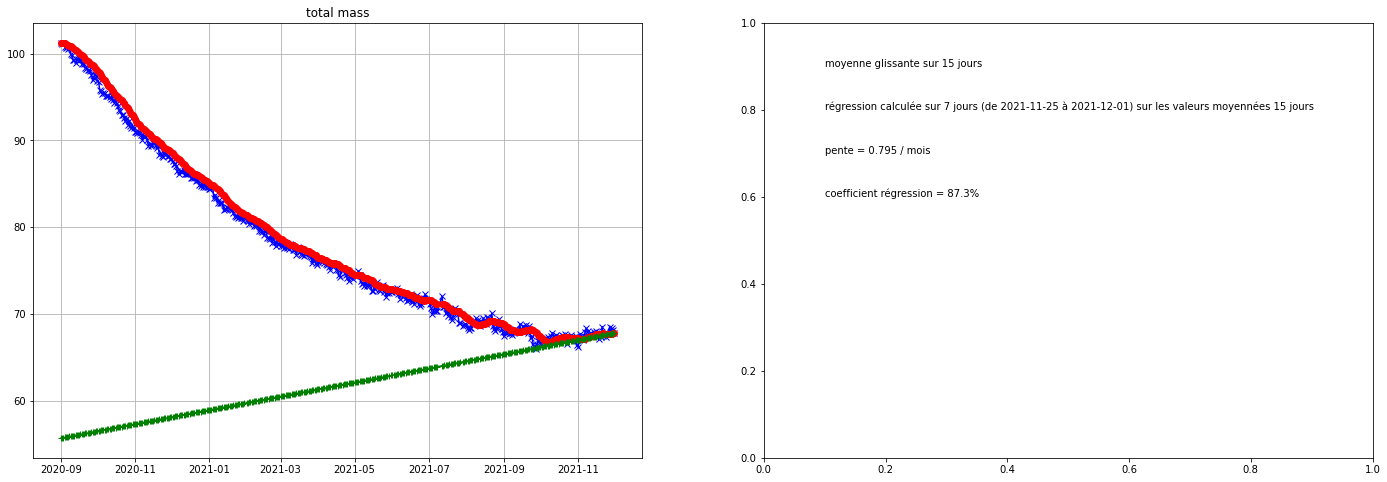

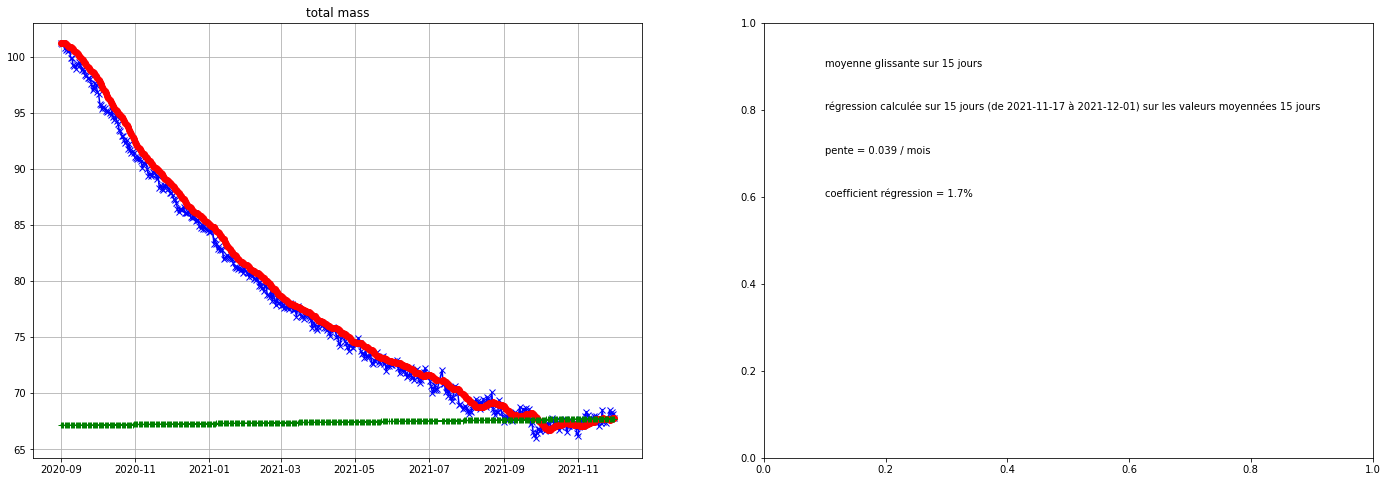

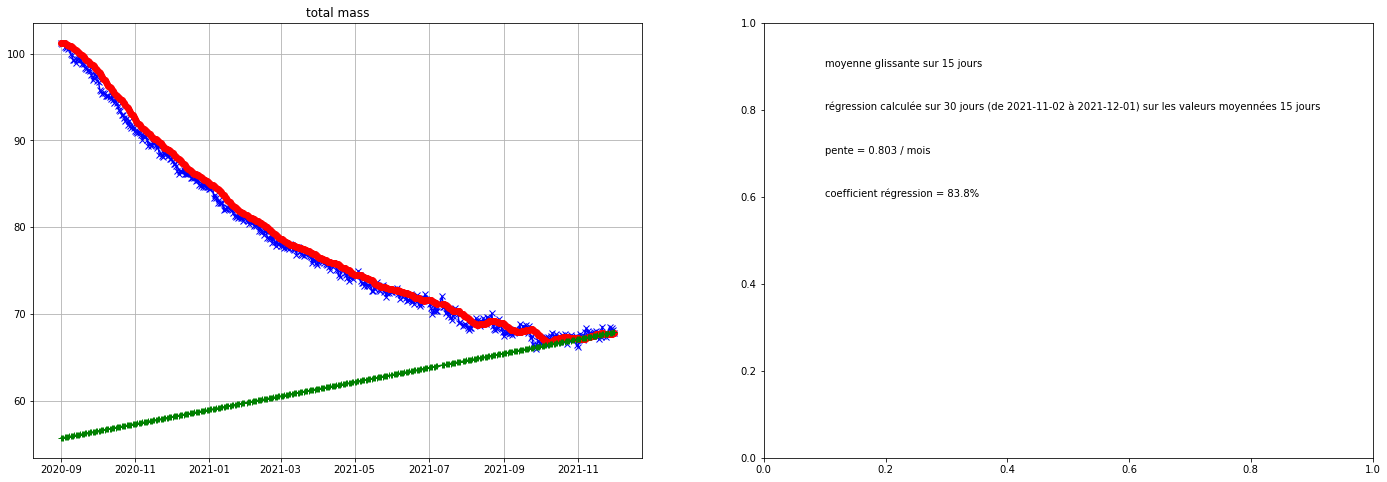

In [10]:
for n_reg in n_reg_list:
    graph.plot_weight(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

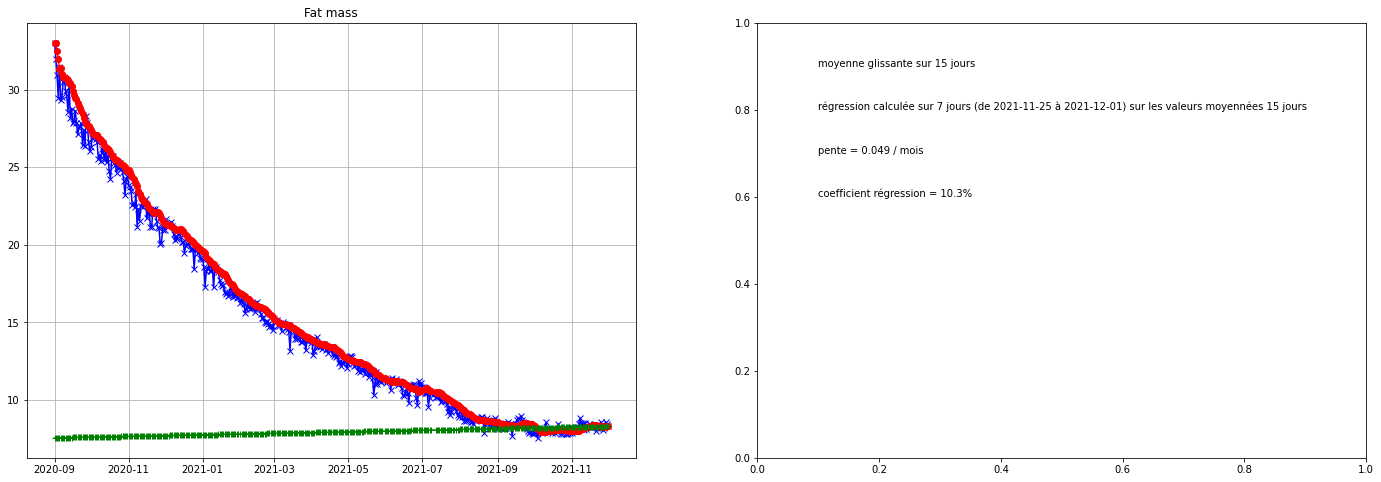

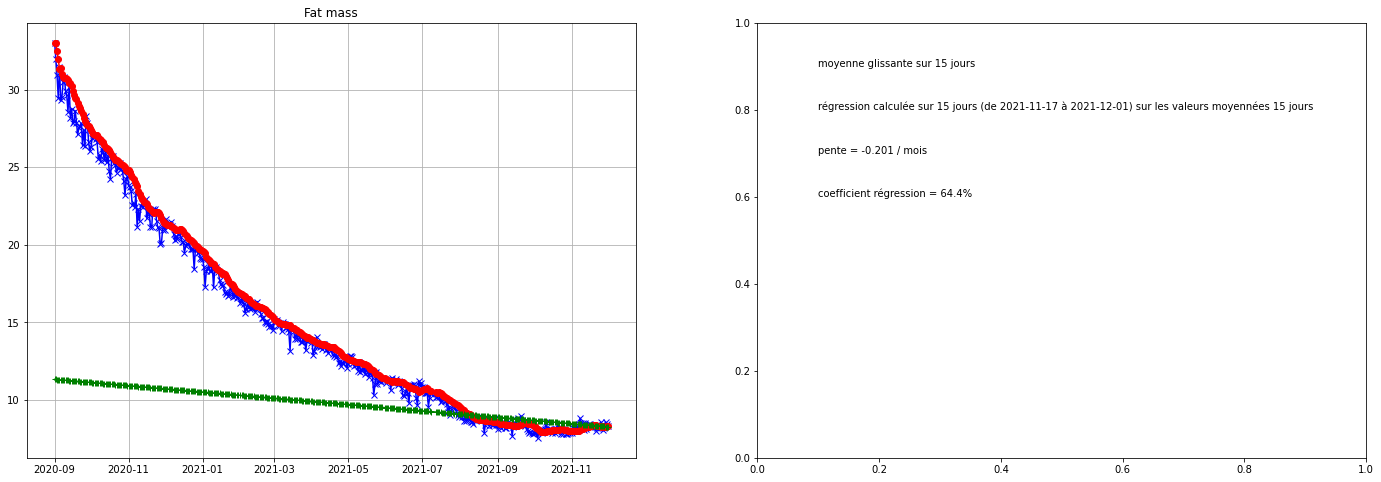

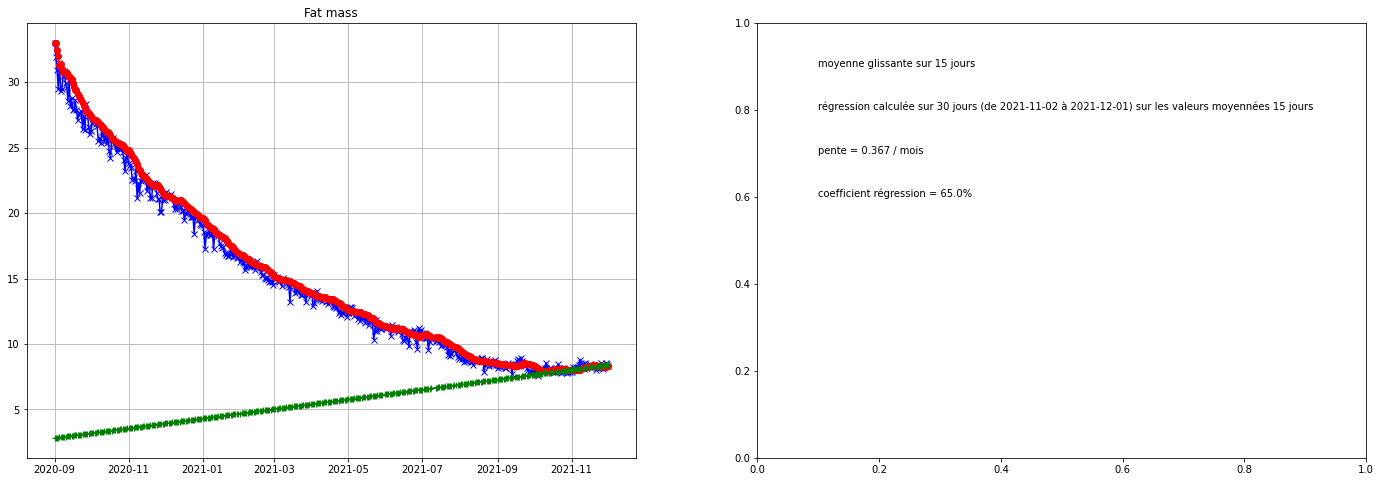

In [11]:
for n_reg in n_reg_list:
    graph.plot_fat(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

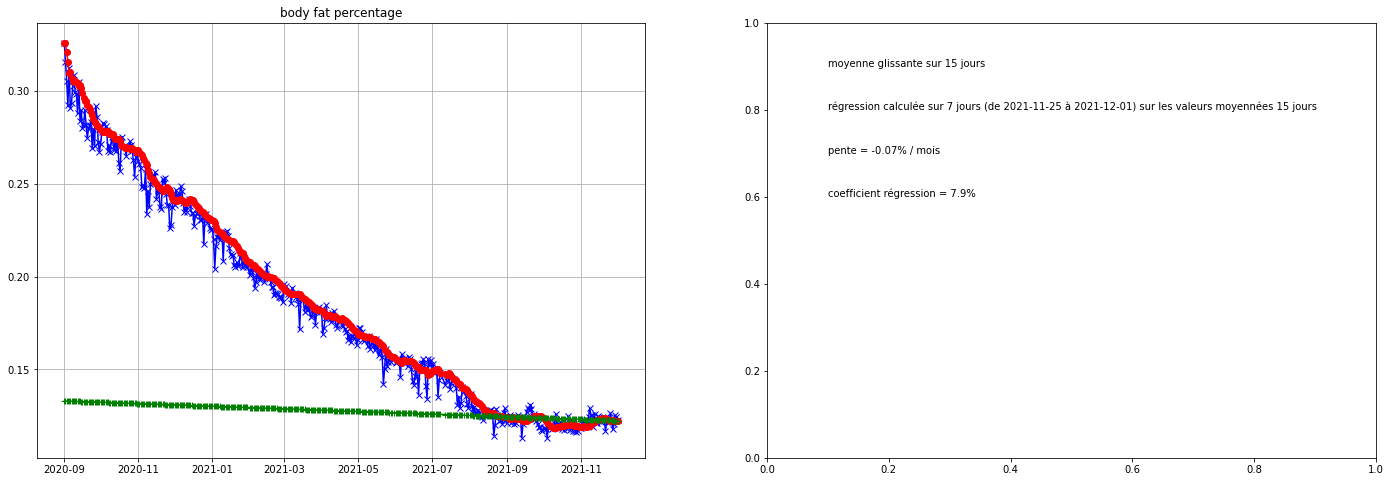

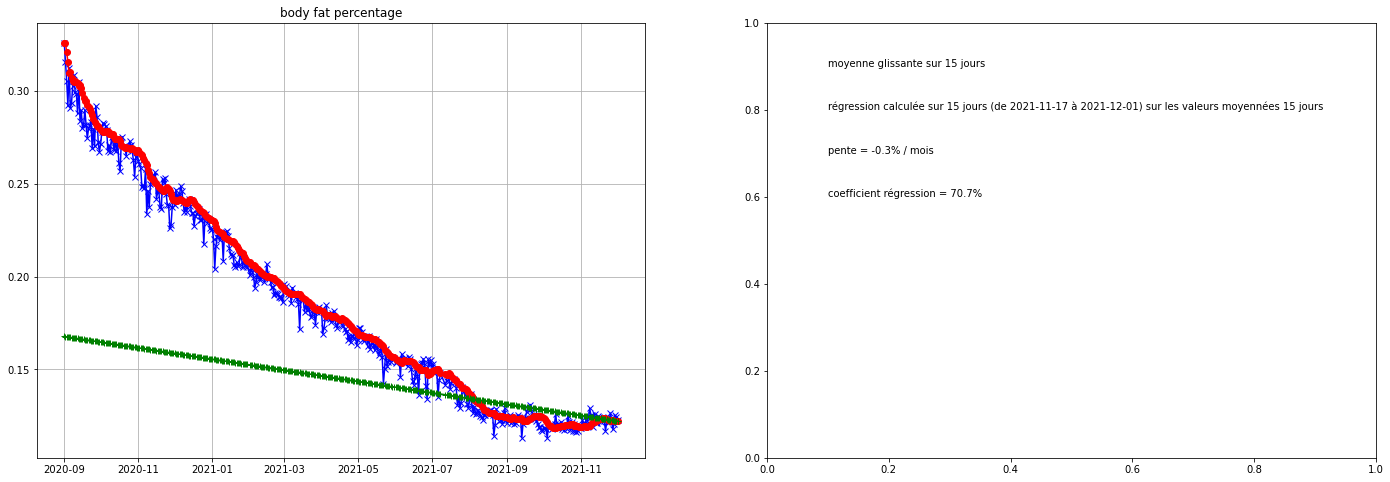

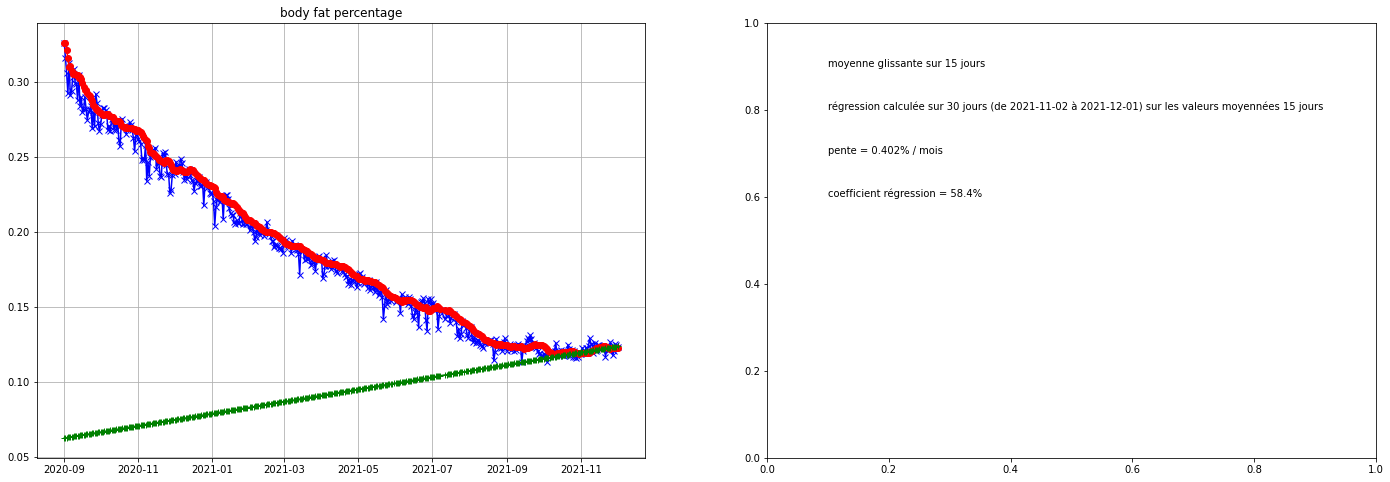

In [12]:
for n_reg in n_reg_list:
    graph.plot_body_fat_percentage(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

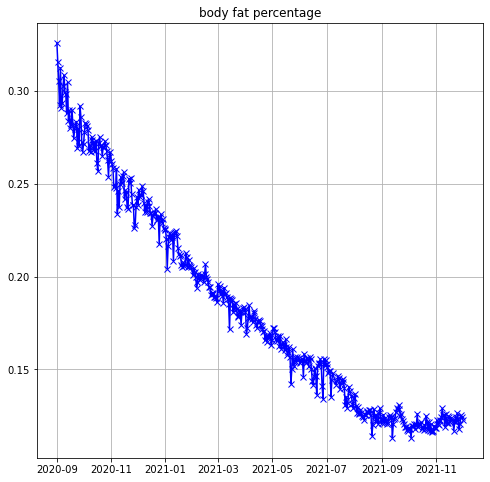

In [13]:
graph.plot_body_fat_percentage(rolling_average=False, n_avg=15, linear_regression=False, n_reg=n_reg)

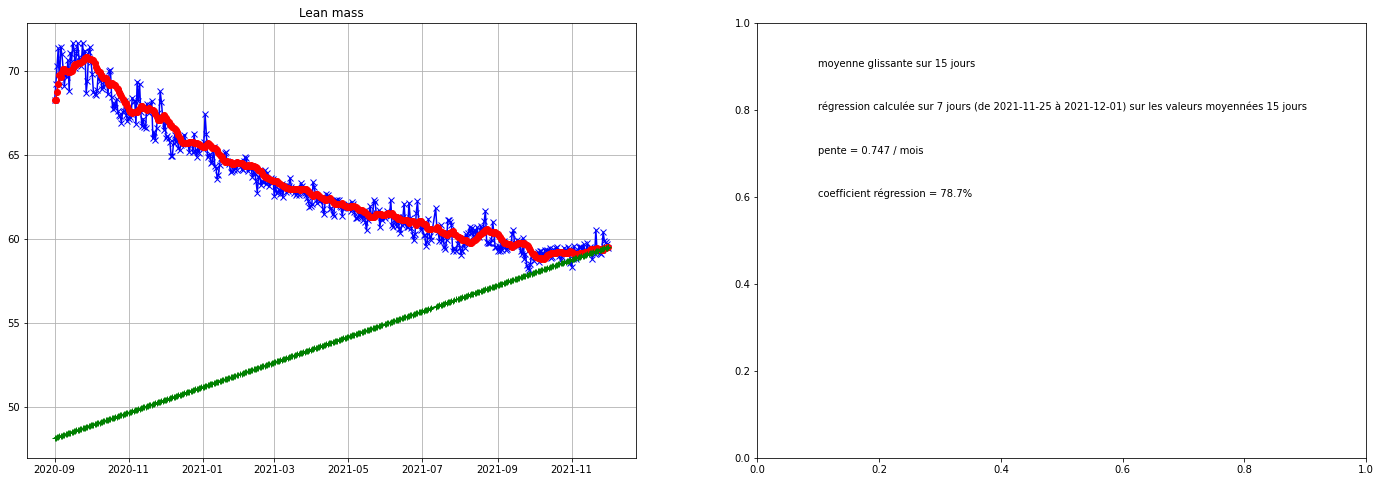

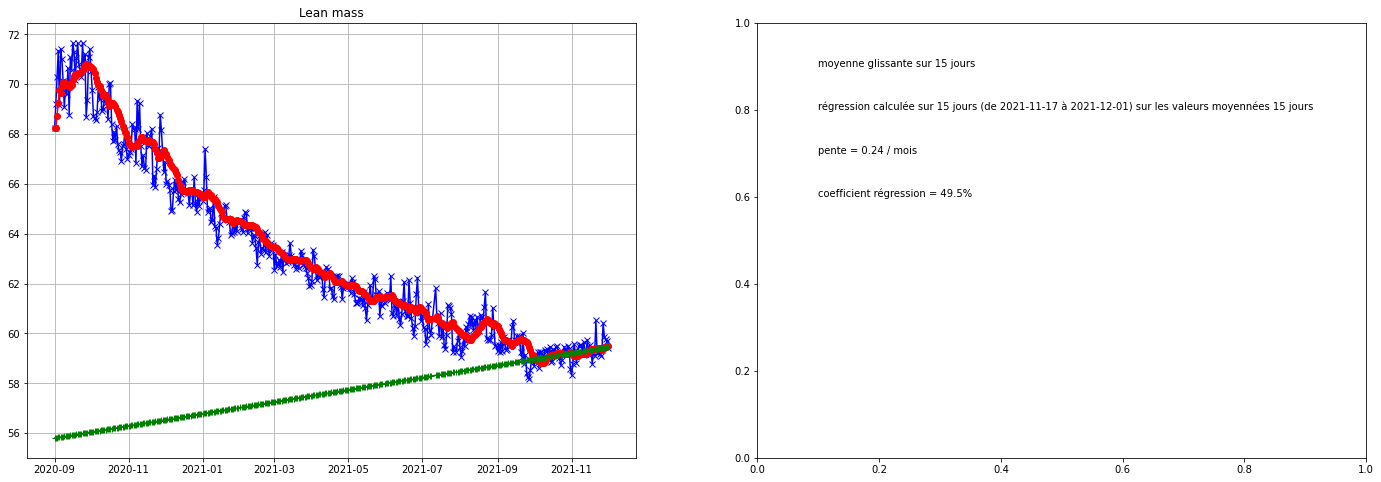

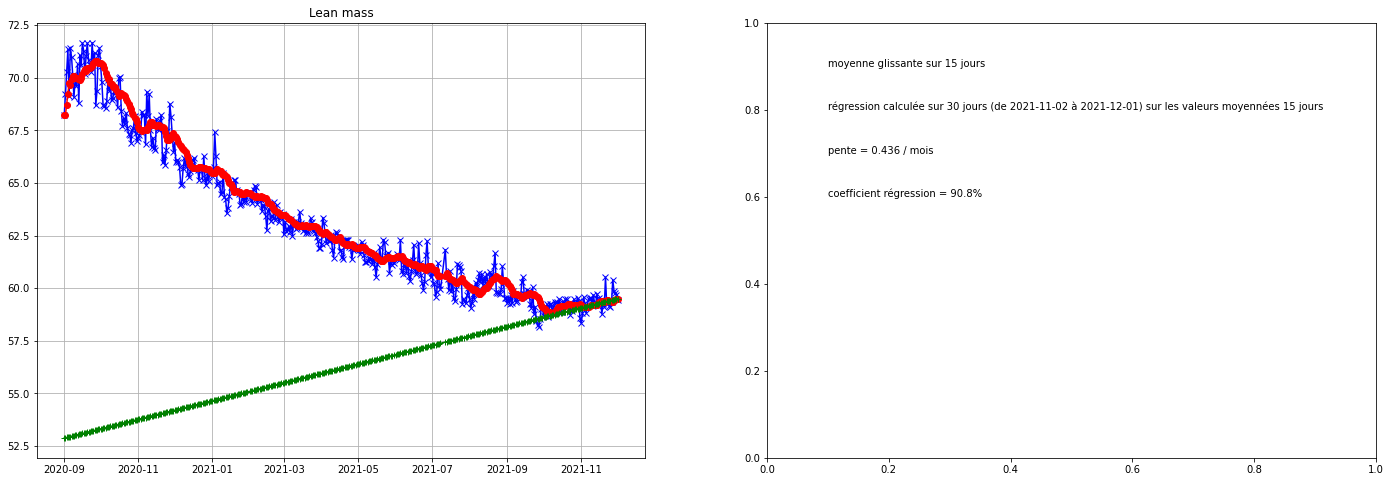

In [14]:
for n_reg in n_reg_list:
    graph.plot_lean_mass(rolling_average=True, n_avg=15, linear_regression=True, n_reg=n_reg)

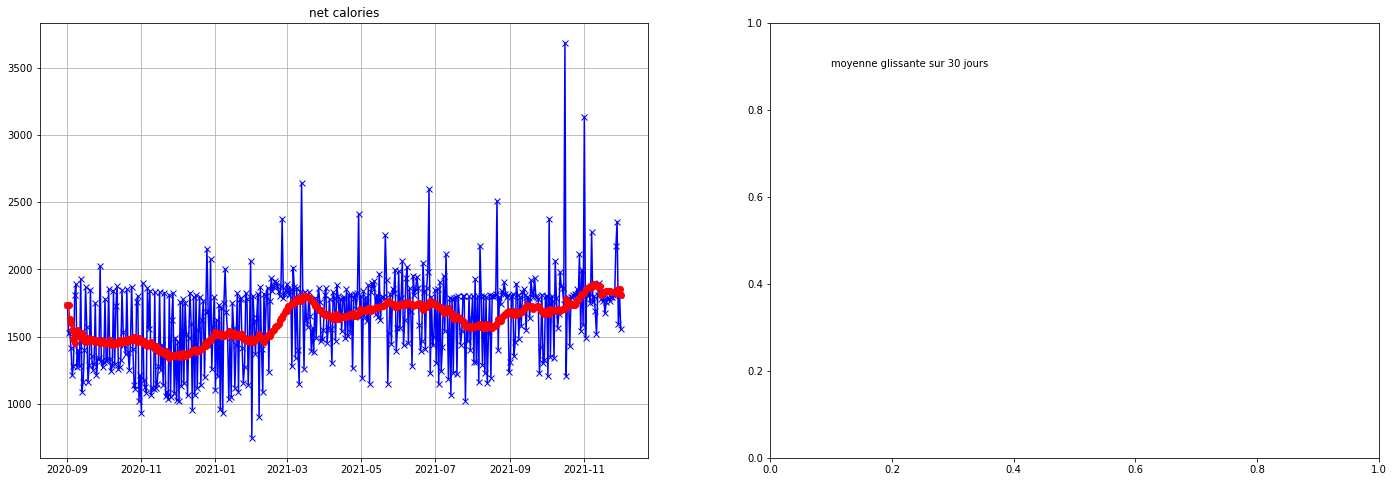

In [15]:
graph.plot_calories_net(rolling_average=True, n_avg=30)

# Zoom 90 jours

In [16]:
over_last_days = 90

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

graph = Display(window_daily_mass_measurements, window_daily_data)

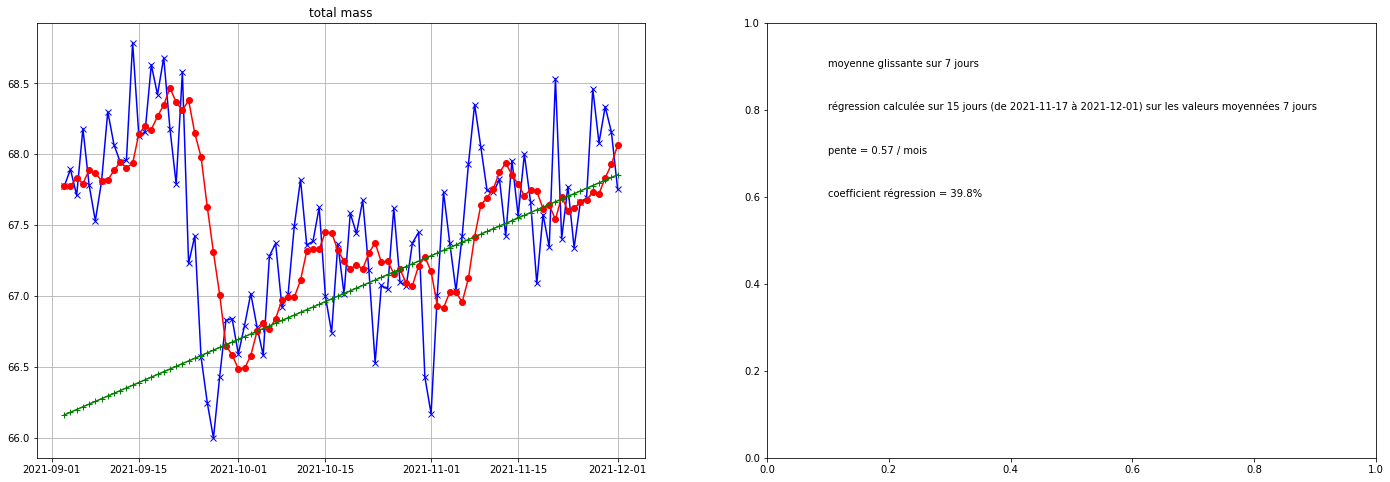

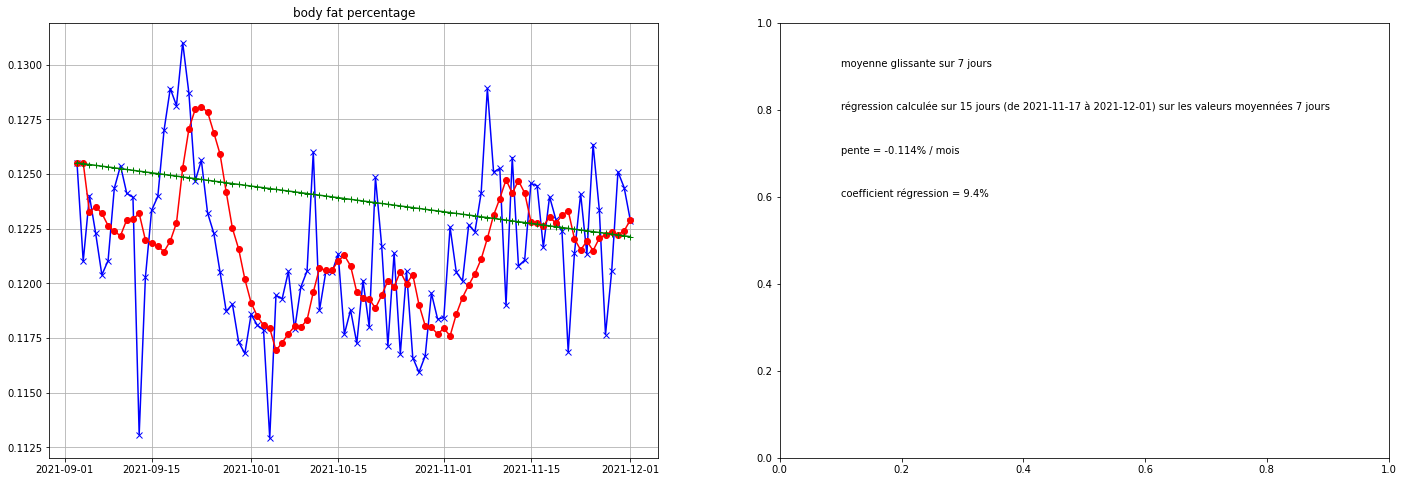

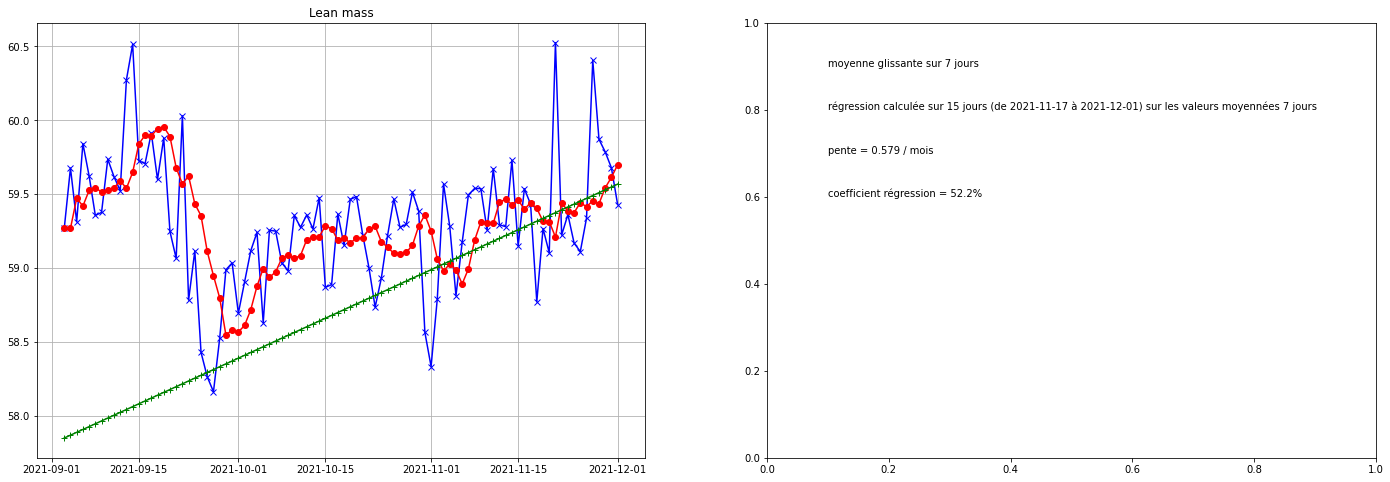

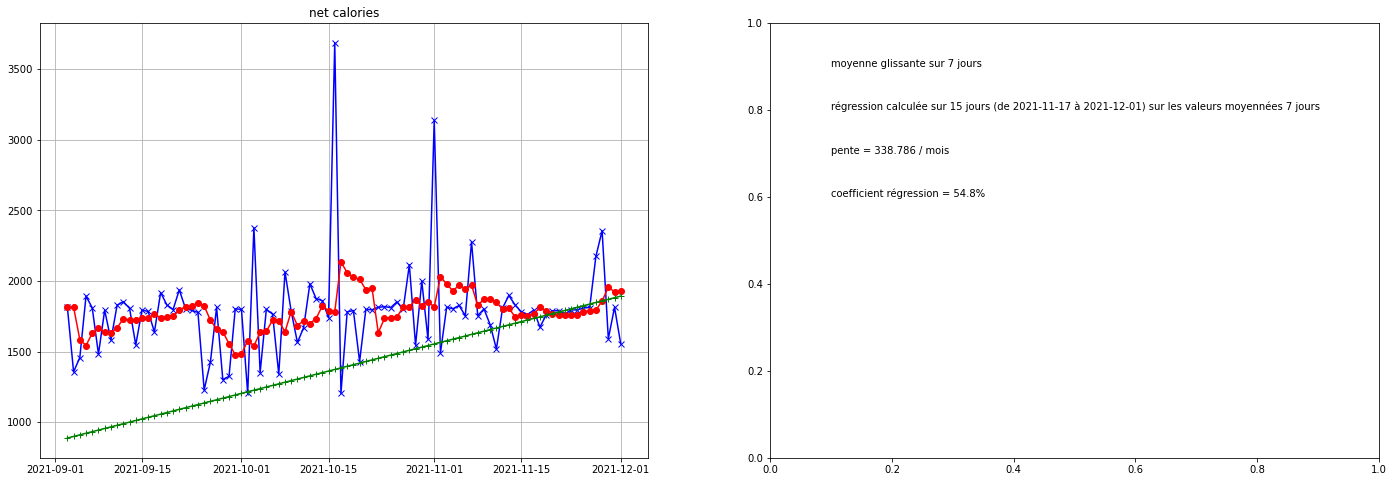

In [17]:
n_reg_list = [15]

for n_reg in n_reg_list:
    graph.plot_weight(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_body_fat_percentage(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    graph.plot_lean_mass(rolling_average=True, n_avg=7, linear_regression=True, n_reg=n_reg)
    
graph.plot_calories_net(rolling_average=True, n_avg=7, linear_regression=True, n_reg=15)


# Some exploratory analysis

### First, correlation between net calories and rate of mass loss

In [18]:
class ExploratoryAnalysis():
    """
    Class that provides some analysis on the data
    """
       
    def __init__(self, window_daily_mass_measurements, window_daily_data):
        """Constructor. Uses the formats viewed  in the GetData class

        Args:
        
            window_daily_mass_measurements ([type]): 
            
                # format is :
                # [ { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   { 'date' : date_object, 'mt' : list of total mass measurements of the day (floats), 
                #     'mg' : list of total mass measurements of the day (floats) },
                #   ...
                # ]
                
            window_daily_data ([type]): [description]
            
                # format is :
                # [ { 'date' : date_object, 'masse_totale' : total mass (float), 'masse_grasse' : fat mass (float),
                #     'calories_in' : kcals (float), 'glucides' : float, 'lipides' : float, 'proteines' : float, 'calories_exercice': float,
                #     'calories_cardio': float, 'calories_strength': float },
                # ....
                # ]    
                
        """
        
        self.daily_mass_measurements = window_daily_mass_measurements
        self.daily_data = window_daily_data
        
    def __rolling_average(self, x, n_avg=7):
        """takes a np.array of values, and returns the np.array of the rolling averages
        
        Parameters:
        -----------
        x (np.array) : the array of values on which to calculate the averages
        n_avg (int) : the length of the sequences to calculate averages on
        
        raises an error if n_avg > length of x
        
        Returns:
        --------
        x_avg : a np.array of the same length as x
        x_avg[i] is the average of values x[max(0,i-n_avg)] to x[i-1] included
        NB : the first n_avg-1 values in x_avg are averages calculated over shorter periods than n_avg
        """
        
        if n_avg > len(x):
            raise NameError('attempting to calculate rolling averages of size superior to the length of data')
        else:
            x_avg = np.zeros(shape=len(x))
            x_avg[0] = x[0]
            for i in range(1,len(x)):
                id = max(0, i-n_avg)
                x_avg[i] = np.mean(x[id:i])
            return x_avg
        
    def test__rolling__average(self):
            
        x = np.array([ 1.0, 5.0, 6.0, 7.0, 8.0, 0.0, 2.0, 5.0, 3.0, 4.0, 5.0, 8.0 ])
        # for n_avg = 3 :
        x_avg_expected = np.array([ 1.0, 1.0, 3.0, 4.0, 6.0, 7.0, 5.0, 3.333333, 2.333333, 3.3333333, 4.0, 4.0])
            
        x_avg = self.__rolling_average(x, n_avg=3)
        
        print(f'expecting {x_avg_expected}')
        print(f'calculating {x_avg}')
        
    def __regression_values(self, y, n_reg=30):
        """takes a np.array of values y, and returns the np.array of regression rates over intervals of size n_reg

        Args:
        -----
            y ([np.array]): values to calculate the regression rate upon.
            n_reg ([int]): length of the regression
            
        Returns:
        --------
            y_rate ([np.array]) : regression rates.
            
        y_rate is a np.array of the same length as y
        y_rate[i] is :
        - the slope of the regression of y[i-n_reg], y[i-n_reg+1], ... , y[i-1] vs [0,1,...,n_reg-1] when i >= n_reg,
        - the slope of regression of y[0], ... , y[i-1] vs [0, ... i-1] when 1 =< i < n_reg
        - y_rate[0] = y[1] - y[0]
        """
        
        if n_reg > len(y):
            raise NameError('attempting to calculate regressions of sample size superior to the length of data')
        else:
            y_rate = np.zeros(shape=len(y))
            
            x = np.array([ k for k in range(n_reg)]).reshape(-1,1)
            for i in range(n_reg, len(y)):
                lr_model = LinearRegression().fit(x, y[i-n_reg:i])
                y_rate[i] = lr_model.coef_[0] * 30 # monthly rate of change
                # print(f'------- calcule indice {i} ---------')
                # print(f'x = {x}')
                # print(f'y = {y[i-n_reg:i]}')
                
            for i in range(1, n_reg):
                x = np.array([ k for k in range(i)]).reshape(-1,1)
                lr_model = LinearRegression().fit(x, y[:i])
                y_rate[i] = lr_model.coef_[0] * 30 # monthly rate of change
                # print(f'------- calcule indice {i} ---------')
                # print(f'x = {x}')
                # print(f'y = {y[:i]}')
                
            y_rate[0] = (y[1] - y[0]) * 30
            
            return y_rate
        
    def test_regression_values(self):
        
        y = np.array([ 1.0, 5.0, 8.0, 9.0, 12.0, 0.0, 2.0, 5.0, 3.0, 4.0, 5.0, 8.0, 12.0, 13.0, 20.0 ])
        # for n_reg = 5 :
        y_rate_expected = np.array([ 4.0, 0.0, 4.0, 3.5, 2.7, 2.6, -0.6, -2.1, -1.8, -1.3, 0.9, 0.5, 0.8, 2.2, 2.5]) * 30
            
        y_rate = self.__regression_values(y, n_reg=5)
        
        print(f'expecting {y_rate_expected}')
        print(f'calculating {y_rate}')
    
    def __basic_scatter(self,
                         data_list,
                         grid=True,
                         title = 'titre'):
        """ Basic display of scatter plot of two series, with a third one used as color legend

        Args:
        -----
            data_list ([dict]): list of dictionnary of datas to display. Format is the following :
                [ { 'date' : datetime.date object, key1(str) : float , key2(str) : float, key3(str) : float } ...]
                key1, key2 and key3 are strings, they are the names of the series to display
                key1.values are x coordinate of data points, 
                key2.values are y coordinate of data points,
                key3.values are values to be used as color        
            grid (bool, optional): [description]. Defaults to True.
            title (str, optional): [description]. Defaults to 'titre'.
            
        Returns : 
        ---------
            none
            
        The method will extract the names of the series, use them on the plot, extract the series, and draw the scatter plot
        """
        
        keys_list = list(data_list[0].keys())
        # print(keys_list)
        name_x = keys_list[1]
        x = np.array([ cdict.get(name_x) for cdict in data_list])
        name_y = keys_list[2]
        y = np.array([ cdict.get(name_y) for cdict in data_list])
        name_z = keys_list[3]
        z = np.array([ cdict.get(name_z) for cdict in data_list])
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 10))
        im = ax.scatter(x, y, c=z)
        fig.colorbar(im, ax=ax)
        
        if grid: ax.grid()
        if title: ax.set_title(title)
        
        ax.set_xlabel(name_x)
        ax.set_ylabel(name_y)
        
        return fig
    
    def draw_correlation(self,
                         dates,
                         name_x, name_y, name_z,
                         x,y,z,
                         mode_3d = False,
                         title = "",
                         grid=True,
                         **kwargs):
        """ method to draw the correlation between x and y, as z as color or altitude (in 3D mode)

        Args:
        -----
            dates ([datetime.date]) : list of datetime.date objects
            name_x ([string]): name of the x serie
            name_y ([string]): name of the y serie
            name_z ([string]): name of the z serie
            x,y,z ([np.arrays]) : arrays of floats to use for the plot
            mode_3d (bool, optional): if True, will use 3D scatter method. Defaults to False.
            title (str, optional): title of the plot. Defaults to "".
        """        
        
        # basic checks
        if (len(x) != len(y)) or (len(x) != len(z)) or (len(y) != len(z)):
            raise NameError('Attempting to draw series of different lengths')
            exit
        
        # create list of dictionnaries to pass to the scatter method
        data_list=[]
        for i in range(len(x)):
            cdict = dict([('date',dates[i]), 
                          (name_x, x[i]), 
                          (name_y, y[i]), 
                          (name_z, z[i]) 
                         ])
            data_list.append(cdict)
            
        # call plot method
        self.__basic_scatter(data_list, title=title, grid=grid, **kwargs)
        
    def test_draw_correlation(self):
        """Test method
        """
        
        dates = [ cdict.get('date') for cdict in self.daily_data ]
        name_x = 'masse_totale'
        name_y = 'masse_grasse'
        name_z = 'masse_totale'
        x = np.array([ cdict.get(name_x) for cdict in self.daily_data ])
        y = np.array([ cdict.get(name_y) for cdict in self.daily_data ])
        z = np.array([ cdict.get(name_z) for cdict in self.daily_data ])
        title = 'correlation mt vs mg'
        name_z = 'masse_totale_c'
        self.draw_correlation(dates, name_x=name_x, name_y=name_y, name_z=name_z, x=x, y=y, z=z, title=title)
    
    def __basic_scatter2(self,
                        data_list, 
                        grid=True,
                        title='titre',
                        time_horizon=7
                        ):
        
        """Private method for basic scatterplot of two data, using a third one for color
        
        Parameters :
        ------------
        data_list (list of dictionnaries) : this is the data, format is 
            [ { 'date' : datetime.date object, 'x' : float , 'y' : float, 'c' : float } ...]
            x,y coordinates of data points, c float to be used as color
        grid (bool, optional): [présence ou pas de la grille]. Defaults to True.
        title(string, optional): [titre]. Defaults to 'titre'
        time_horizon (int, optional) : Number to be used to calculate averages on x and y. Defaults to 7.

        Returns:
        --------
        fig, ax : scatter plot
        """
        
        dates = [ cdict.get('date') for cdict in data_list ]
        dates_num = [ d.toordinal() for d in dates]
        x = [ cdict.get('x') for cdict in data_list ]
        y = [ cdict.get('y') for cdict in data_list ]
        color = [ cdict.get('c') for cdict in data_list ]
        
        def roll_avg(x, n_avg=time_horizon):
            # plot moyenne glissante sur les n_moy dernières valeurs
            x_avg = np.zeros(shape=len(x))
            x_avg[0] = x[0]
            for i in range(1,len(x)):
                id = max(0, i-n_avg+1)
                x_avg[i] = np.mean(x[id:i])
            return x_avg
        
        x_avg = roll_avg(x, time_horizon)
        y_avg = roll_avg(y, time_horizon)
        
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,8))
        im = ax1.scatter(x_avg, y_avg, c=color)
        fig.colorbar(im, ax=ax1)
        
        if grid: ax1.grid()
        if title: ax1.set_title(title)
        
        ax2.text(0.1,0.9,f'dates de {dates[0]} à {dates[-1]} ({len(dates)} jours)')
        ax2.text(0.1,0.8,f'data moyennées sur {time_horizon} jours')
                
        return fig
    
    def correlate_mt_mg(self, **kwargs):
        
        data_list = [ dict( [ ('date', cdict.get('date')), 
                              ('x', np.mean(cdict.get('mt'))),
                              ('y', np.mean(cdict.get('mg'))),
                              ('c', np.mean(cdict.get('mt'))) 
                            ] ) for cdict in self.daily_mass_measurements ]
                     
        self.__basic_scatter2(data_list, 
                             title='correlate fat mass vs total mass', 
                             **kwargs)
        
    def correlate_bfperc_mt(self,
                            **kwargs):
        
        data_list = [ dict( [ ('date', cdict.get('date')), 
                             ('y', np.mean(cdict.get('masse_grasse')) / np.mean(cdict.get('masse_totale'))),
                             ('x', np.mean(cdict.get('masse_totale'))),
                             ('c', np.mean(cdict.get('masse_totale'))) 
                            ] ) for cdict in self.daily_data ]
        
        self.__basic_scatter2(data_list,
                             title='body fat % vs total mass',
                             **kwargs)
        
    def correlate_bfperc_rate_c_net(self,
                                    n_avg = 7,
                                    n_reg = 30,
                                    **kwargs):
        
        """
        NB : validé sous Excel Suivi_Poids.xls"""
        
        dates = np.array([ cdict.get('date') for cdict in self.daily_data ])  # get dates
        bfperc = np.array([ cdict.get('masse_grasse')/cdict.get('masse_totale') for cdict in self.daily_data ])  # calculate daily values of body fat percentage
        c_net = np.array([ cdict.get('calories_in')-cdict.get('calories_exercice') for cdict in self.daily_data ]) # calculate daily values of calories net
        
        bfperc_avg = self.__rolling_average(bfperc, n_avg) # calculate the averages of bfperc over n_avg days
        c_net_avg = self.__rolling_average(c_net, n_avg) # calculate the averages of c_net over n_avg days
        
        bfperc_avg_rate = self.__regression_values(bfperc_avg, n_reg)  # calculate the rate of change of bfperc_avg over n_reg days
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
        dates = dates[n_avg+n_reg:]
        bfperc = bfperc[n_avg+n_reg:]
        bfperc_avg = bfperc_avg[n_avg+n_reg:]
        bfperc_avg_rate = bfperc_avg_rate[n_reg+n_avg:]
        c_net_avg = c_net_avg[n_avg+n_reg:]
        
        ax.set_title(f'{n_reg}-day change rate of {n_avg}-day averaged bf% values, vs {n_avg}-day average calories net')
        im = ax.scatter(c_net_avg, bfperc_avg_rate, c=bfperc_avg)
        fig.colorbar(im, ax=ax)
        ax.set_xlabel(f'{n_avg}-day average of calories net')
        ax.set_ylabel(f'{n_reg}-day change rate of {n_avg}-day body fat percentage')
        ax.grid(True)
        
        plt.show()
        
    def correlate_mt_rate_c_net(self,
                                n_avg=7,
                                n_reg=30,
                                **kwargs):
        
        dates = np.array([ cdict.get('date') for cdict in self.daily_data ])  # get dates
        mt = np.array([ cdict.get('masse_totale') for cdict in self.daily_data ])  # calculate daily values of total mass
        c_net = np.array([ cdict.get('calories_in')-cdict.get('calories_exercice') for cdict in self.daily_data ]) # calculate daily values of calories net
        
        mt_avg = self.__rolling_average(mt, n_avg) # calculate the averages of total mass mt over n_avg days
        c_net_avg = self.__rolling_average(c_net, n_avg) # calculate the averages of c_net over n_avg days
        
        mt_avg_rate = self.__regression_values(mt_avg, n_reg)  # calculate the rate of change of averaged total mass over n_reg days
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
        dates = dates[n_avg+n_reg:]
        mt = mt[n_avg+n_reg:]
        mt_avg = mt_avg[n_avg+n_reg:]
        mt_avg_rate = mt_avg_rate[n_reg+n_avg:]
        c_net_avg = c_net_avg[n_avg+n_reg:]
        
        ax.set_title(f'{n_reg}-day change rate of {n_avg}-day averaged total mass values, vs {n_avg}-day average calories net')
        im = ax.scatter(c_net_avg, mt_avg_rate, c=mt_avg)
        fig.colorbar(im, ax=ax)
        ax.set_xlabel(f'{n_avg}-day average of calories net')
        ax.set_ylabel(f'{n_reg}-day change rate of {n_avg}-day total mass')
        ax.grid(True)
        
        plt.show()
  
    def correlate_lean_mass_rate_c_net(self,
                                n_avg=7,
                                n_reg=30,
                                **kwargs):
        
        dates = np.array([ cdict.get('date') for cdict in self.daily_data ])  # get dates
        mt = np.array([ cdict.get('masse_totale') for cdict in self.daily_data ])  # calculate daily values of total mass
        lm = np.array([ cdict.get('masse_totale')-cdict.get('masse_grasse') for cdict in self.daily_data ])  # calculate daily values of lean mass
        c_net = np.array([ cdict.get('calories_in')-cdict.get('calories_exercice') for cdict in self.daily_data ]) # calculate daily values of calories net
        
        lm_avg = self.__rolling_average(lm, n_avg) # calculate the averages of lean mass lm over n_avg days
        mt_avg = self.__rolling_average(mt, n_avg) # calculate the averages of total mass mt over n_avg days
        c_net_avg = self.__rolling_average(c_net, n_avg) # calculate the averages of c_net over n_avg days
        
        lm_avg_rate = self.__regression_values(lm_avg, n_reg)  # calculate the rate of change of averaged total mass over n_reg days
        
        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
        
        dates = dates[n_avg+n_reg:]
        mt = mt[n_avg+n_reg:]
        mt_avg = mt_avg[n_avg+n_reg:]
        lm = lm[n_avg+n_reg:]
        lm_avg = lm_avg[n_avg+n_reg:]
        lm_avg_rate = lm_avg_rate[n_avg+n_reg:]
        
        c_net_avg = c_net_avg[n_avg+n_reg:]
        
        ax.set_title(f'{n_reg}-day change rate of {n_avg}-day averaged lean mass values, vs {n_avg}-day average calories net')
        im = ax.scatter(c_net_avg, lm_avg_rate, c=mt_avg)
        fig.colorbar(im, ax=ax)
        ax.set_xlabel(f'{n_avg}-day average of calories net')
        ax.set_ylabel(f'{n_reg}-day change rate of {n_avg}-day total mass')
        ax.grid(True)
        
        plt.show()

# Analyse sur 360 jours

In [19]:
over_last_days = 360

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

expl = ExploratoryAnalysis( window_daily_mass_measurements, window_daily_data)

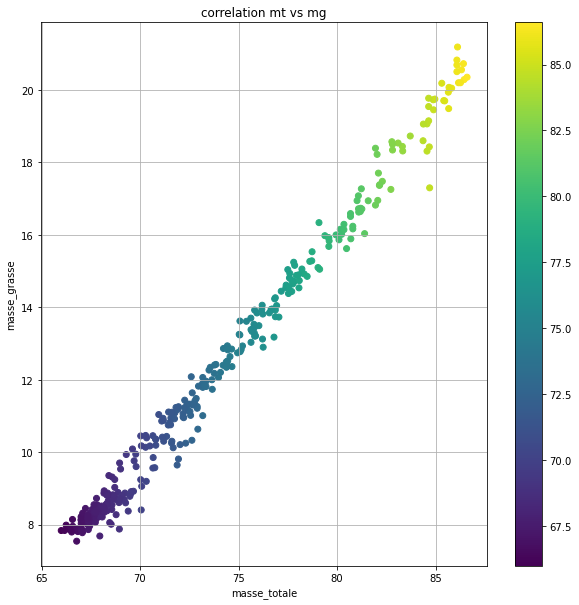

In [20]:
expl.test_draw_correlation()

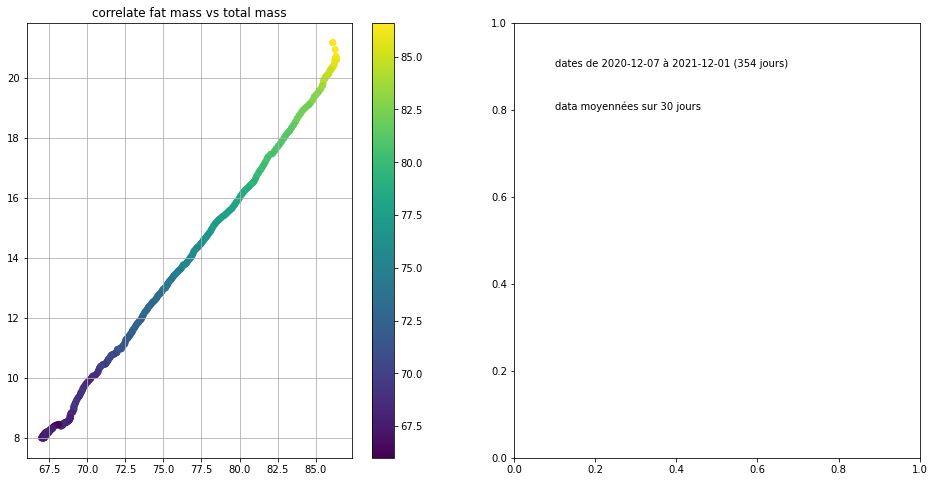

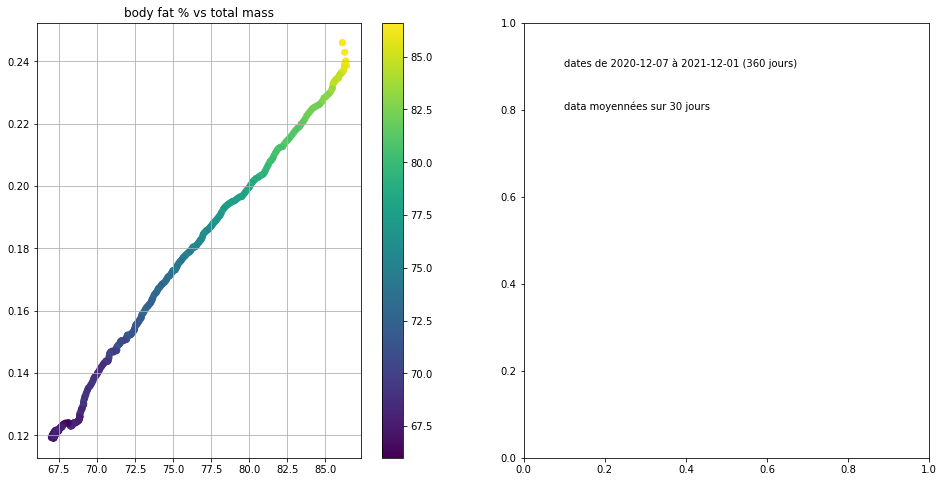

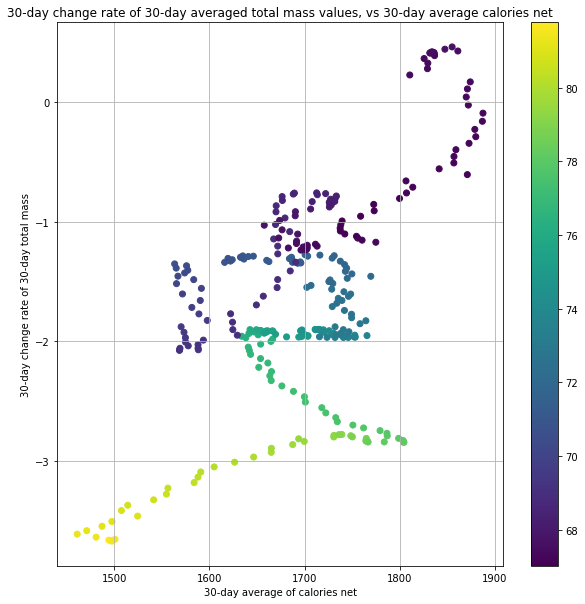

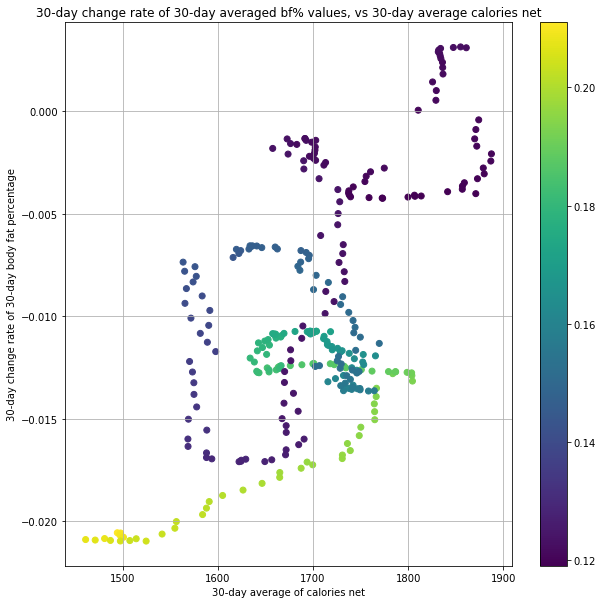

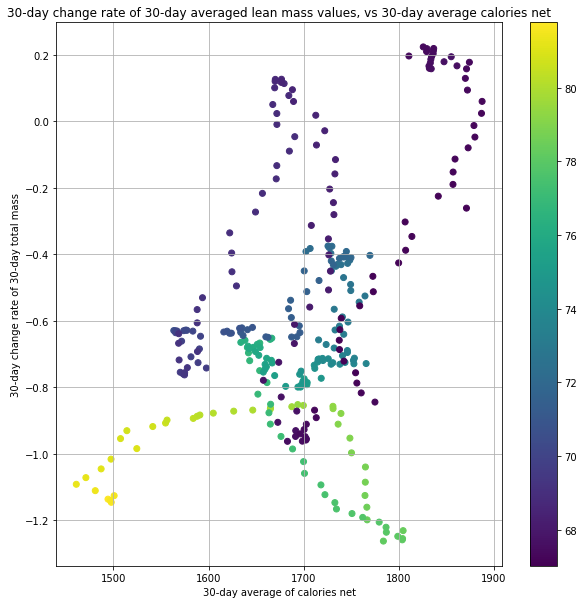

In [21]:
expl.correlate_mt_mg(time_horizon=30)

expl.correlate_bfperc_mt(time_horizon=30)

# correlate between total mass change rate and average net calories

expl.correlate_mt_rate_c_net(n_reg=30, n_avg=30)

# correlate between body fat change rate and average net calories

expl.correlate_bfperc_rate_c_net(n_reg=30, n_avg=30)

# correlate between lean mass change rate and average net calories

expl.correlate_lean_mass_rate_c_net(n_reg=30, n_avg=30)

# Analyse sur 120 jours

In [22]:
over_last_days = 120

window_daily_mass_measurements = ds.get_window_daily_mass_measurements(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )
window_daily_data = ds.get_window_daily_data(start_date = datetime.date.today() - datetime.timedelta(days = over_last_days), end_date = datetime.date.today() )

expl = ExploratoryAnalysis( window_daily_mass_measurements, window_daily_data)

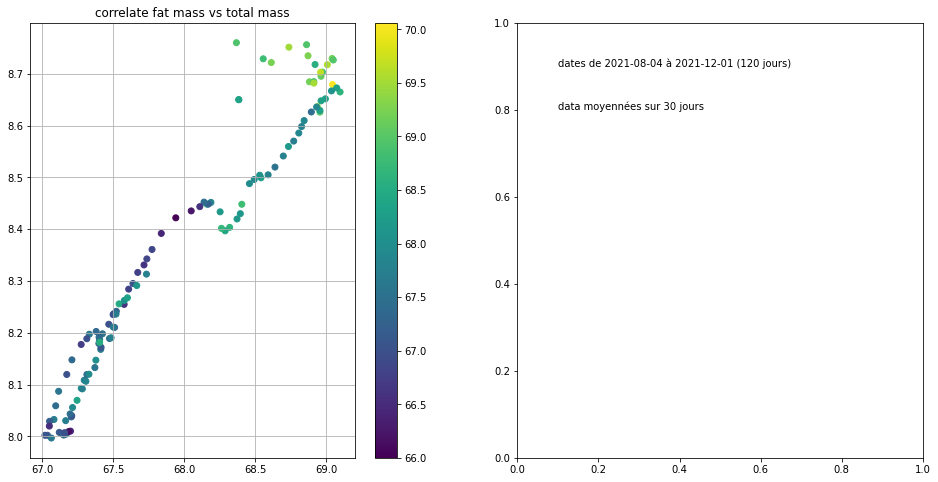

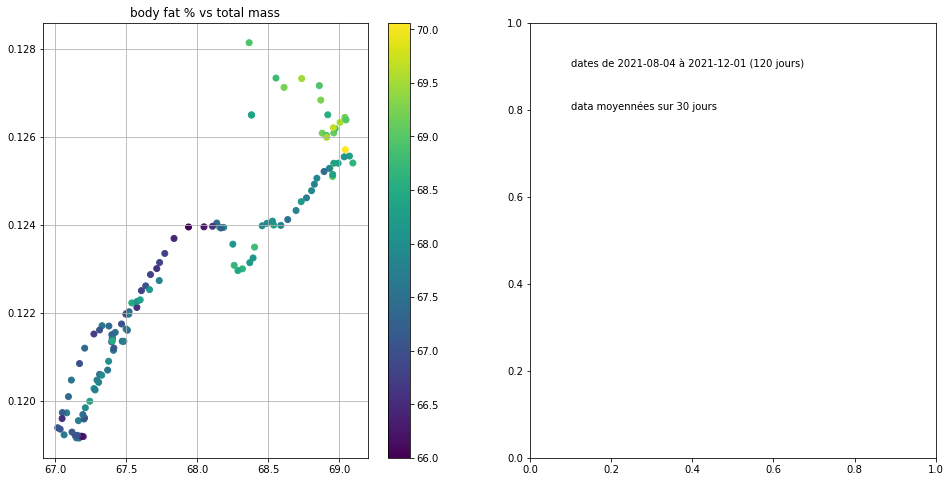

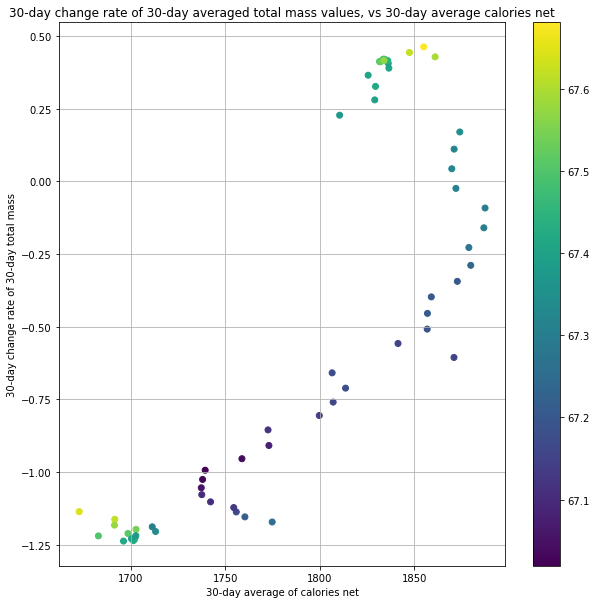

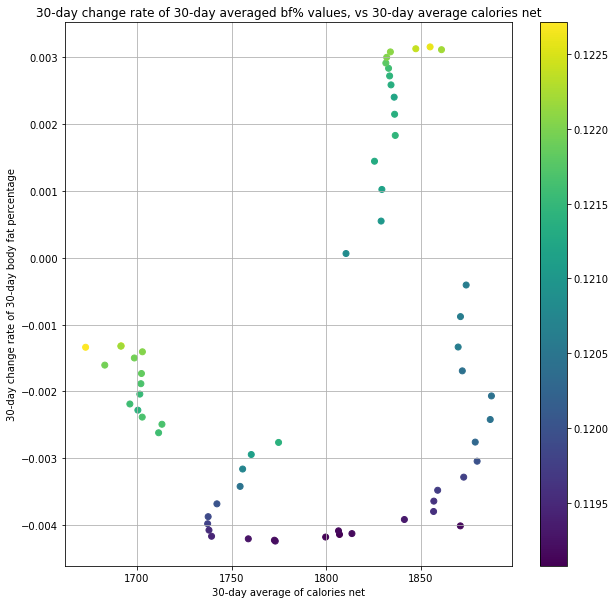

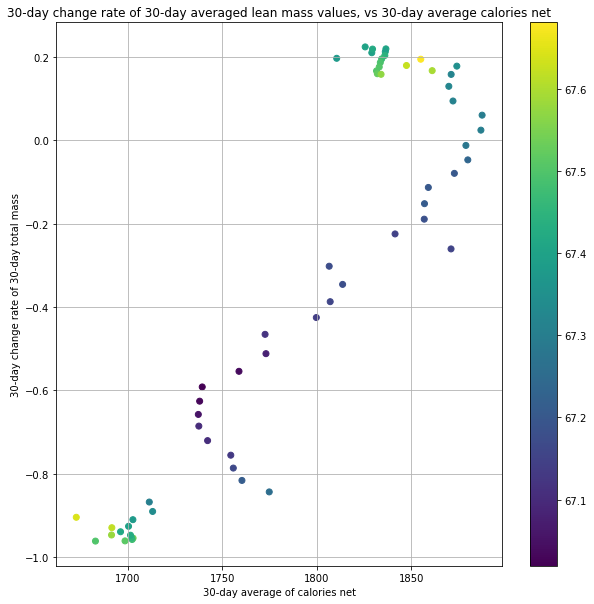

In [23]:
expl.correlate_mt_mg(time_horizon=30)

expl.correlate_bfperc_mt(time_horizon=30)

expl.correlate_mt_rate_c_net(n_reg=30, n_avg=30)

expl.correlate_bfperc_rate_c_net(n_reg=30, n_avg=30)

expl.correlate_lean_mass_rate_c_net(n_reg=30, n_avg=30)

# CONCLUSIONS :
- sur les 30 derniers jours, on voit que la perte de masse sèche devrait s'arrêter autour de 1900 kcals net / jour
- mais que l'on devrait malgré tout continuer à perdre du bf% (autour de -0.3% / mois)
- rôle de l'exercice ??

# Passage sous Pandas DataFrame

In [24]:
cdict = ds.daily_data[0]
columns_names = list(cdict.keys())
print(columns_names)

['date', 'masse_totale', 'masse_grasse', 'calories_in', 'glucides', 'lipides', 'proteines', 'calories_exercice', 'calories_cardio', 'calories_strength']


In [25]:
dict_for_df = dict( (c_name, []) for c_name in columns_names )

In [26]:
for cdict in ds.daily_data:
    for c_name in columns_names:
        dict_for_df[c_name].append(cdict.get(c_name))

In [27]:
df = pd.DataFrame.from_dict(dict_for_df)

In [28]:
df

,date,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength
0,2020-08-01,107.15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-08-02,106.85,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-08-03,107.15,0.0,1918.0,195.0,89.0,72.0,0.0,0.0,0.0
3,2020-08-05,105.50,0.0,1949.0,213.0,83.0,86.0,0.0,0.0,0.0
4,2020-08-06,106.45,0.0,1937.0,134.0,66.0,59.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
869,2022-12-27,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
870,2022-12-28,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
871,2022-12-29,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
872,2022-12-30,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [29]:
# removing rows with missing values in total mass, fat mass, or calories in.

df.drop(df[df['masse_totale']==0.0].index, inplace=True)

df.drop(df[df['masse_grasse']==0.0].index, inplace=True)

df.drop(df[df['calories_in']==0.0].index, inplace=True)


In [30]:
df

,date,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength
6,2020-08-09,107.250,37.190,1862.0,232.0,70.0,66.0,0.0,0.0,0.0
8,2020-08-11,104.650,33.150,1773.0,186.0,49.0,104.0,0.0,0.0,0.0
9,2020-08-12,104.350,33.800,1893.0,220.0,59.0,90.0,0.0,0.0,0.0
10,2020-08-13,104.400,34.340,1823.0,223.0,72.0,7.0,0.0,0.0,0.0
11,2020-08-14,104.500,33.850,1891.0,218.0,62.0,84.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
474,2021-11-27,68.460,8.055,2173.0,232.0,51.0,186.0,0.0,0.0,0.0
475,2021-11-28,68.080,8.209,2356.0,266.0,67.0,160.0,0.0,0.0,0.0
476,2021-11-29,68.335,8.549,2331.0,258.0,50.0,199.0,740.0,0.0,740.0
477,2021-11-30,68.155,8.477,1813.0,205.0,44.0,144.0,0.0,0.0,0.0


In [31]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 472 entries, 6 to 478
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   date               472 non-null    object 
 1   masse_totale       472 non-null    float64
 2   masse_grasse       472 non-null    float64
 3   calories_in        472 non-null    float64
 4   glucides           472 non-null    float64
 5   lipides            472 non-null    float64
 6   proteines          472 non-null    float64
 7   calories_exercice  472 non-null    float64
 8   calories_cardio    472 non-null    float64
 9   calories_strength  472 non-null    float64
dtypes: float64(9), object(1)
memory usage: 40.6+ KB


In [32]:
df.describe()

,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength
count,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000,472.000000
mean,78.746913,15.424047,1905.186441,181.669492,58.792373,135.324153,272.228814,167.680085,104.548729
std,10.779456,7.154717,205.618314,45.348390,15.400227,36.008651,298.332369,277.244635,203.052600
min,66.000000,7.541667,1399.000000,43.000000,8.000000,7.000000,0.000000,0.000000,0.000000
25%,69.156875,8.882500,1800.000000,154.000000,48.000000,115.000000,0.000000,0.000000,0.000000
50%,75.706667,13.270000,1838.500000,176.000000,58.000000,136.000000,198.000000,0.000000,0.000000
75%,86.129167,20.215000,1927.000000,206.000000,69.000000,155.000000,549.000000,326.750000,120.000000
max,107.250000,37.190000,3837.000000,485.000000,125.000000,263.000000,1041.000000,1030.000000,920.000000


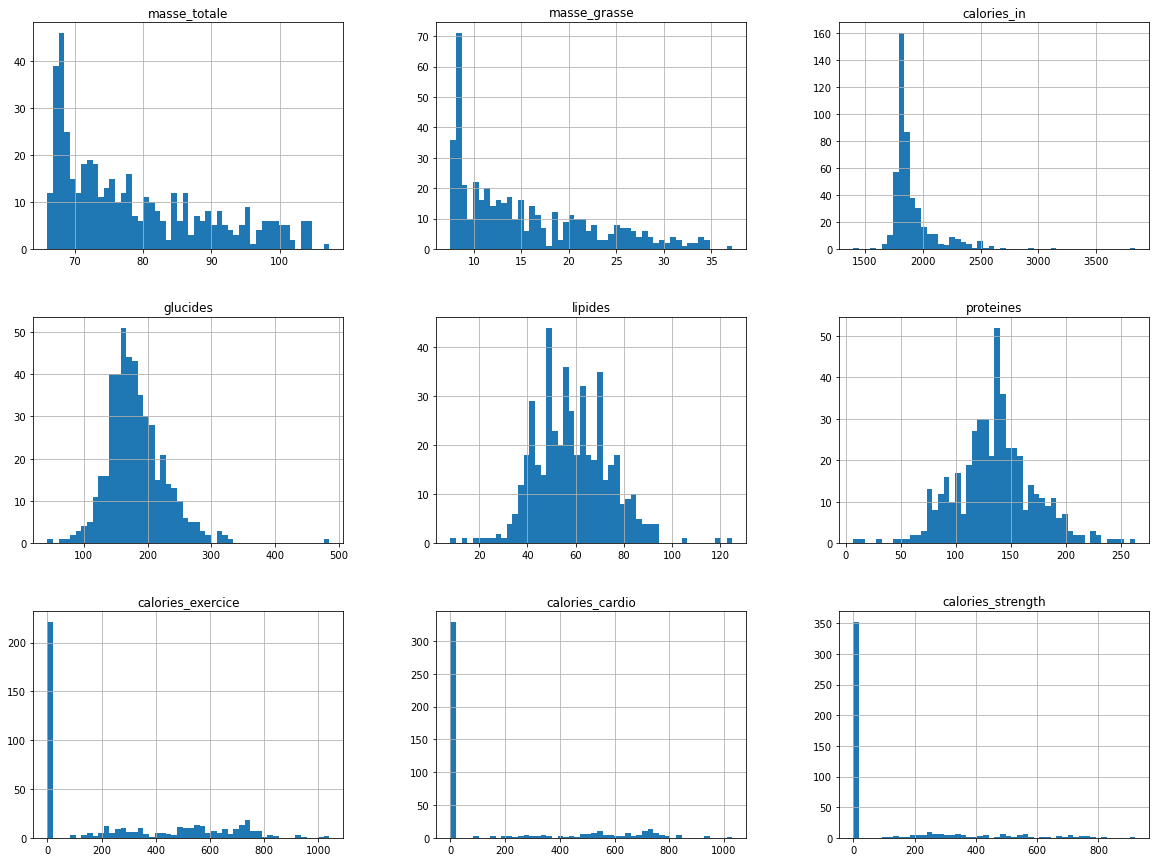

In [33]:
df.hist(bins=50, figsize=(20,15))
plt.show()

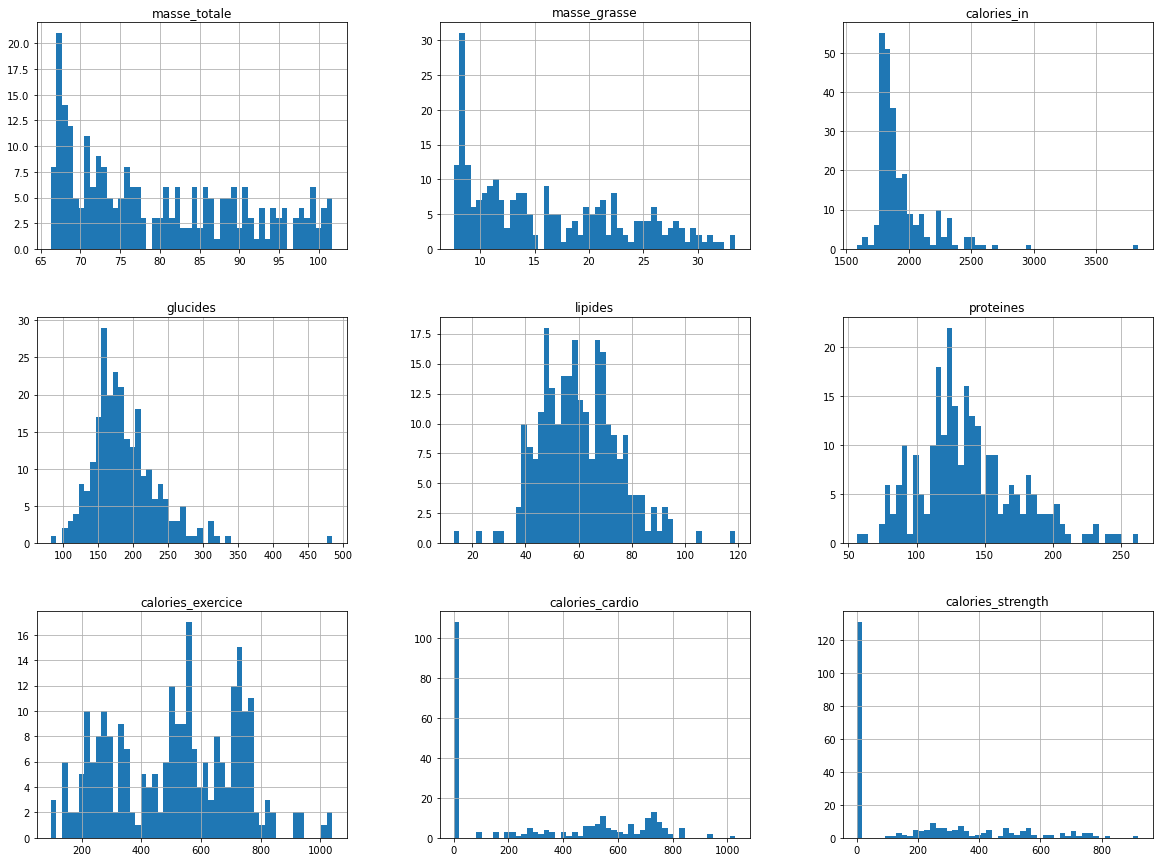

In [34]:
df_cal_non_zero = df[df['calories_exercice']>0]
df_cal_non_zero.hist(bins=50, figsize=(20,15))
plt.show()

## Recherche de la fenêtre temporelle pertinente pour les futurs modèles

In [35]:
import statsmodels.api as sm

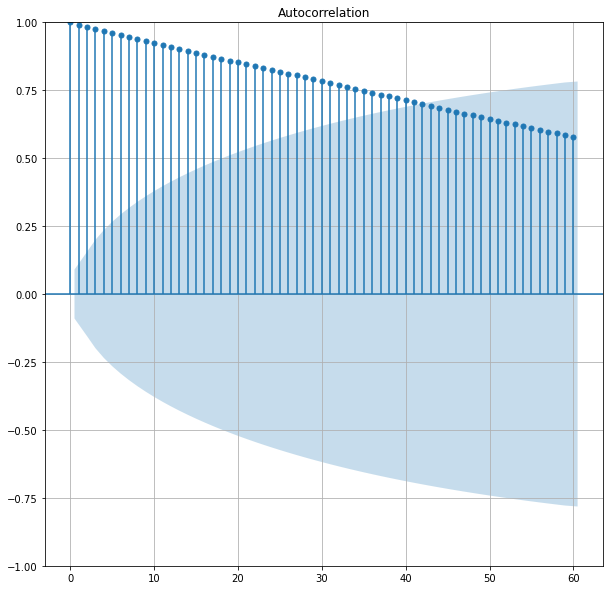

In [36]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sm.graphics.tsa.plot_acf(df['masse_totale'].values, ax=ax, lags=60, use_vlines=True, alpha=0.05)
plt.grid()
plt.show()

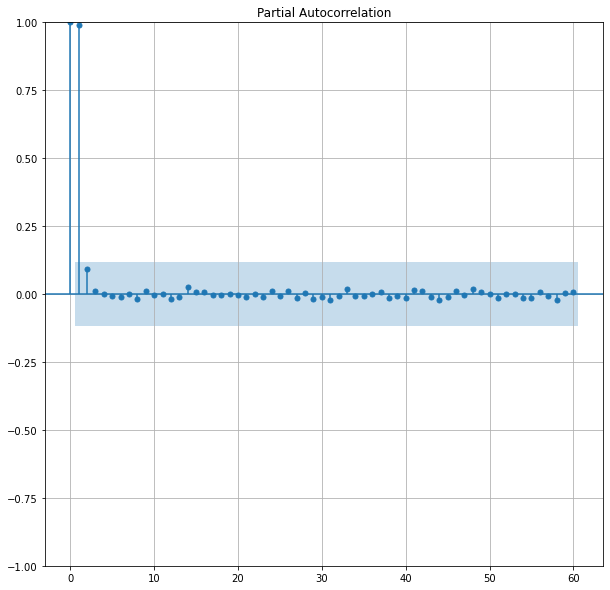

In [37]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sm.graphics.tsa.plot_pacf(df['masse_totale'].values, ax=ax, lags=60, use_vlines=True, alpha=0.01, method='ywm')
plt.grid()
plt.show()

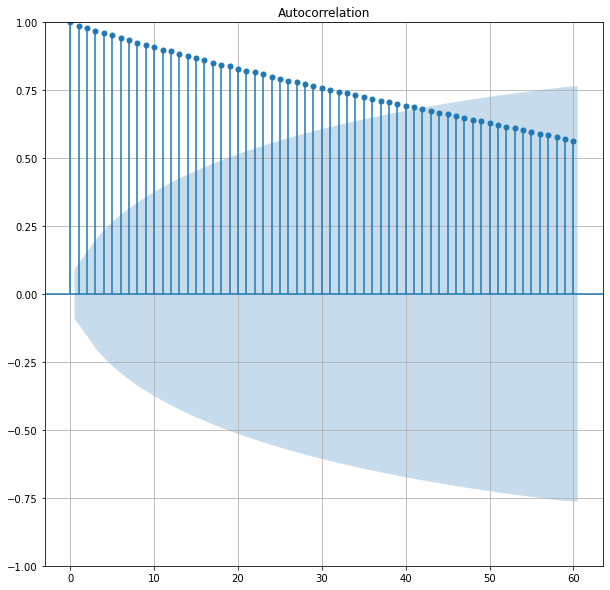

In [38]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sm.graphics.tsa.plot_acf(df['masse_grasse'].values, ax=ax, lags=60, use_vlines=True, alpha=0.05)
plt.grid()
plt.show()

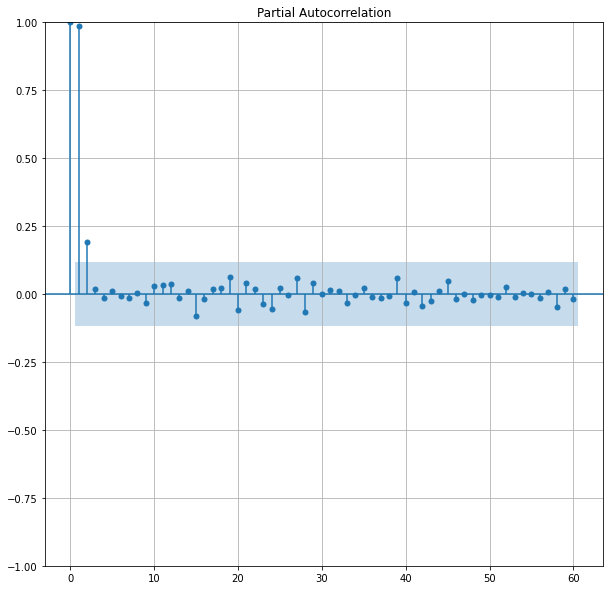

In [39]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
sm.graphics.tsa.plot_pacf(df['masse_grasse'].values, ax=ax, lags=60, use_vlines=True, alpha=0.01, method='ywm')
plt.grid()
plt.show()

## On note donc a priori une composante AR(1), voire AR(2) : la valeur à J+1 est fortement corrélée à la valeur à J, voire J-1

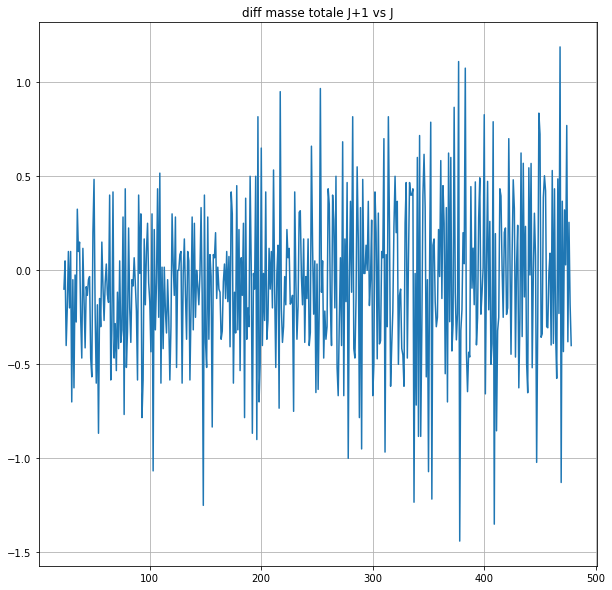

In [60]:

fig, ax = plt.subplots(1,1,figsize=(10,10))
df['masse_totale'].diff(1).plot(ax=ax, title='diff masse totale J+1 vs J')
plt.grid()
plt.show()

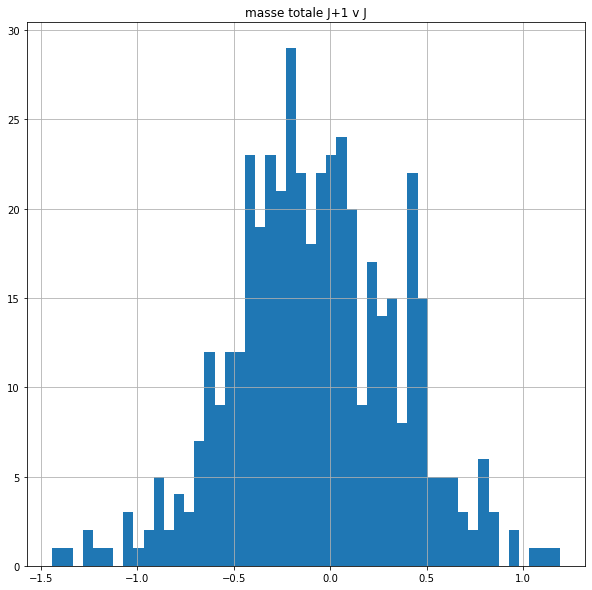

moyenne = -0.07345394736842106


In [65]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
df['masse_totale'].diff(1).hist(ax=ax, bins=50)
ax.set_title(label='masse totale J+1 v J')
ax.grid(True)
plt.show()
print(f'moyenne = {df["masse_totale"].diff(1).mean()}')


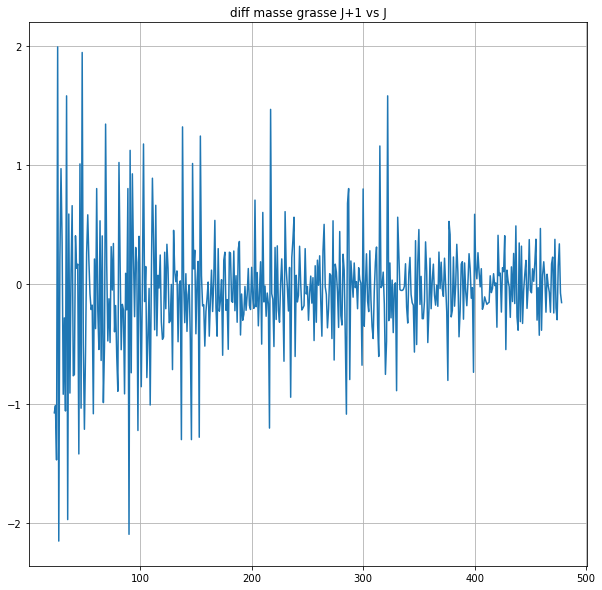

moyenne = -0.05415570175438593


In [66]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
df['masse_grasse'].diff(1).plot(ax=ax, title='diff masse grasse J+1 vs J')
plt.grid()
plt.show()
print(f'moyenne = {df["masse_grasse"].diff(1).mean()}')

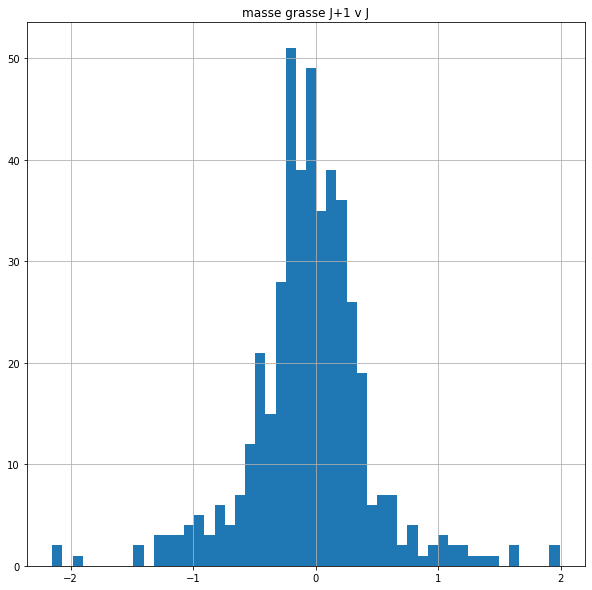

In [67]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
df['masse_grasse'].diff(1).hist(ax=ax, bins=50)
ax.set_title(label='masse grasse J+1 v J')
ax.grid(True)
plt.show()

### Confirmation ici : la différence entre la masse au jour J et au jour J-1 semble centrée légèrement sous 0

 Donc les deltas de J à J+1 semblent être des séries stattionnaires, au sens de moyenne quasi constante (proche de 0) et de variance constante au cours du temps

On va donc créer deux Series J+1 v J pour masse totale et masse grasse

In [68]:
df = df[df['date'] >= datetime.date(2020,9,1)]
df

,date,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,delta_mt,delta_mg,calories_nettes
22,2020-09-01,101.250,33.020,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,0.000,0.000,1734.0
23,2020-09-02,101.150,31.945,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,-0.100,-1.075,1523.0
24,2020-09-03,101.200,30.930,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,0.050,-1.015,1535.0
25,2020-09-04,100.800,29.460,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,-0.400,-1.470,1412.0
26,2020-09-05,100.600,31.450,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,-0.200,1.990,1211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2021-11-27,68.460,8.055,2173.0,232.0,51.0,186.0,0.0,0.0,0.0,0.770,-0.296,2173.0
475,2021-11-28,68.080,8.209,2356.0,266.0,67.0,160.0,0.0,0.0,0.0,-0.380,0.154,2356.0
476,2021-11-29,68.335,8.549,2331.0,258.0,50.0,199.0,740.0,0.0,740.0,0.255,0.340,1591.0
477,2021-11-30,68.155,8.477,1813.0,205.0,44.0,144.0,0.0,0.0,0.0,-0.180,-0.072,1813.0


In [69]:
mt = df['masse_totale'].to_numpy()
mg = df['masse_grasse'].to_numpy()

delta_mt = np.zeros(shape=len(mt))
delta_mg = np.zeros(shape=len(mg))

for i in range(1,len(mt)):
    delta_mt[i] = mt[i] - mt[i-1]
    delta_mg[i] = mg[i] - mg[i-1]

In [70]:
df['delta_mt'] = delta_mt
df['delta_mg'] = delta_mg

In [71]:
df['calories_nettes'] = df['calories_in'] - df['calories_exercice']

In [72]:
df

,date,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,delta_mt,delta_mg,calories_nettes
22,2020-09-01,101.250,33.020,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,0.000,0.000,1734.0
23,2020-09-02,101.150,31.945,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,-0.100,-1.075,1523.0
24,2020-09-03,101.200,30.930,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,0.050,-1.015,1535.0
25,2020-09-04,100.800,29.460,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,-0.400,-1.470,1412.0
26,2020-09-05,100.600,31.450,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,-0.200,1.990,1211.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
474,2021-11-27,68.460,8.055,2173.0,232.0,51.0,186.0,0.0,0.0,0.0,0.770,-0.296,2173.0
475,2021-11-28,68.080,8.209,2356.0,266.0,67.0,160.0,0.0,0.0,0.0,-0.380,0.154,2356.0
476,2021-11-29,68.335,8.549,2331.0,258.0,50.0,199.0,740.0,0.0,740.0,0.255,0.340,1591.0
477,2021-11-30,68.155,8.477,1813.0,205.0,44.0,144.0,0.0,0.0,0.0,-0.180,-0.072,1813.0


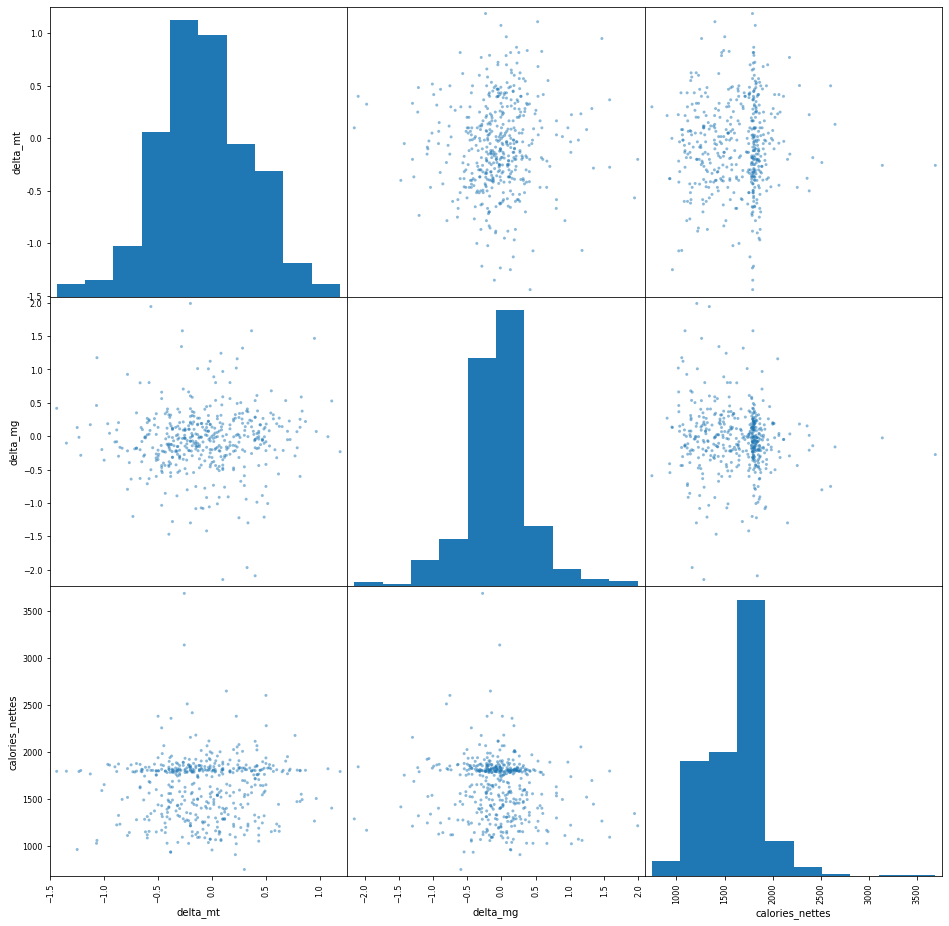

In [73]:
attributes = ['delta_mt', 'delta_mg', 'calories_nettes']
pd.plotting.scatter_matrix(df[attributes], figsize=(16,16))
plt.show()

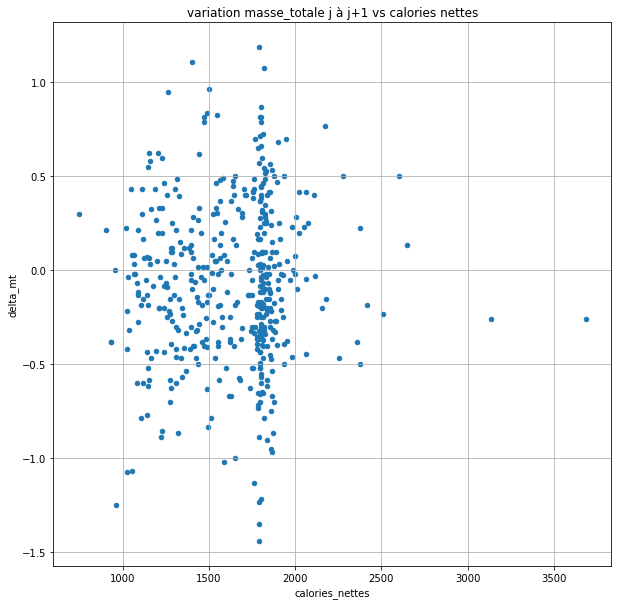

In [74]:
df.plot(kind='scatter', x='calories_nettes', y='delta_mt', alpha=1.0, figsize=(10,10), title='variation masse_totale j à j+1 vs calories nettes')
plt.grid()
plt.show()

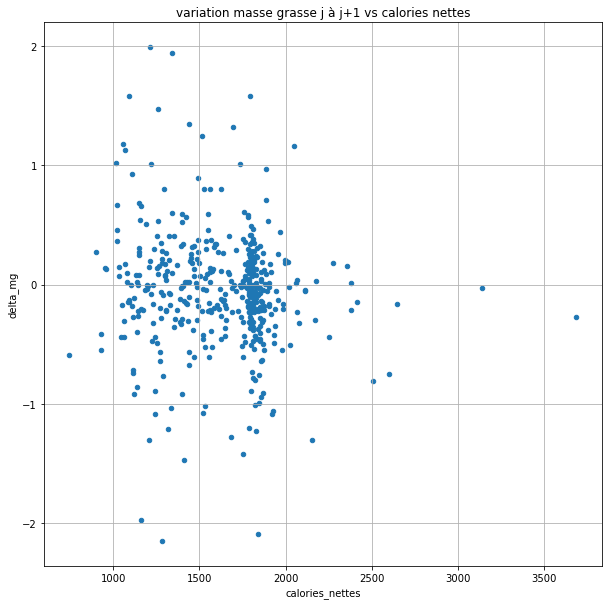

In [75]:
df.plot(kind='scatter', x='calories_nettes', y='delta_mg', alpha=1.0, figsize=(10,10), title='variation masse grasse j à j+1 vs calories nettes')
plt.grid()
plt.show()

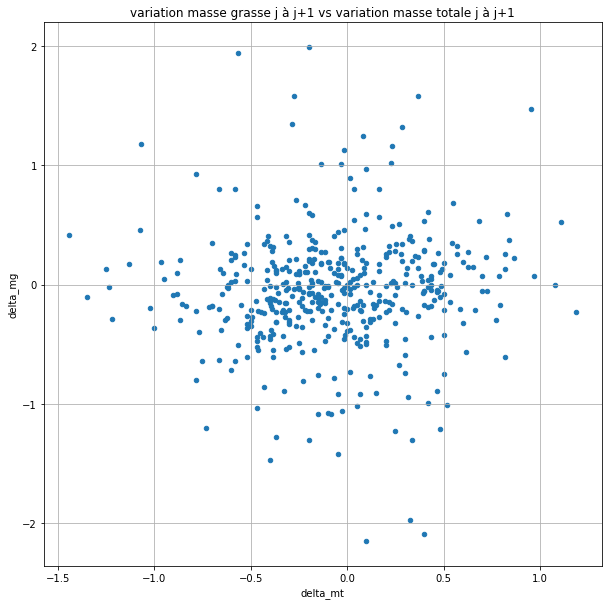

In [76]:
df.plot(kind='scatter', x='delta_mt', y='delta_mg', alpha=1.0, figsize=(10,10), title='variation masse grasse j à j+1 vs variation masse totale j à j+1')
plt.grid()
plt.show()

In [146]:
df.head(10)

,date,masse_totale,masse_grasse,calories_in,glucides,lipides,proteines,calories_exercice,calories_cardio,calories_strength,delta_mt,delta_mg,calories_nettes
22,2020-09-01,101.25,33.020,2015.0,262.0,48.0,120.0,281.0,281.0,0.0,0.00,0.000,1734.0
23,2020-09-02,101.15,31.945,1942.0,162.0,94.0,100.0,419.0,419.0,0.0,-0.10,-1.075,1523.0
24,2020-09-03,101.20,30.930,1938.0,227.0,72.0,93.0,403.0,403.0,0.0,0.05,-1.015,1535.0
25,2020-09-04,100.80,29.460,1851.0,274.0,43.0,91.0,439.0,439.0,0.0,-0.40,-1.470,1412.0
26,2020-09-05,100.60,31.450,1774.0,214.0,54.0,90.0,563.0,563.0,0.0,-0.20,1.990,1211.0
27,2020-09-06,100.70,29.300,1763.0,211.0,57.0,86.0,479.0,479.0,0.0,0.10,-2.150,1284.0
28,2020-09-07,100.50,29.510,2029.0,224.0,92.0,77.0,220.0,220.0,0.0,-0.20,0.210,1809.0
29,2020-09-08,100.60,30.480,1889.0,166.0,80.0,115.0,0.0,0.0,0.0,0.10,0.970,1889.0
30,2020-09-09,99.90,30.830,1872.0,208.0,59.0,121.0,597.0,597.0,0.0,-0.70,0.350,1275.0
31,2020-09-10,99.85,29.910,1980.0,182.0,85.0,111.0,582.0,582.0,0.0,-0.05,-0.920,1398.0


In [158]:
def custom_scatter(dff = df2, 
                   name_x = 'calories_nettes_sum', 
                   name_y1 = 'delta_mt_sum', 
                   name_y2 = 'delta_mg_sum',
                   window_length=30):

        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
        
        x = dff[name_x].to_numpy()
        y1 = dff[name_y1].to_numpy()
        y2 = dff[name_y2].to_numpy()
        z = dff['masse_totale'].to_numpy()

        im = ax[0].scatter(x, y1, c=z)
        fig.colorbar(im, ax=ax)
        ax[0].grid()
        ax[0].set_title(f'{name_y1} vs {name_x}, fenetres de {window_length} jours')
        ax[0].set_xlabel(name_x)
        ax[0].set_ylabel(name_y1)
        
        im = ax[1].scatter(x, y2, c=z)
        ax[1].grid()
        ax[1].set_title(f'{name_y2} vs {name_x}, fenetres de {window_length} jours')
        ax[1].set_xlabel(name_x)
        ax[1].set_ylabel(name_y2)
        
        plt.show()

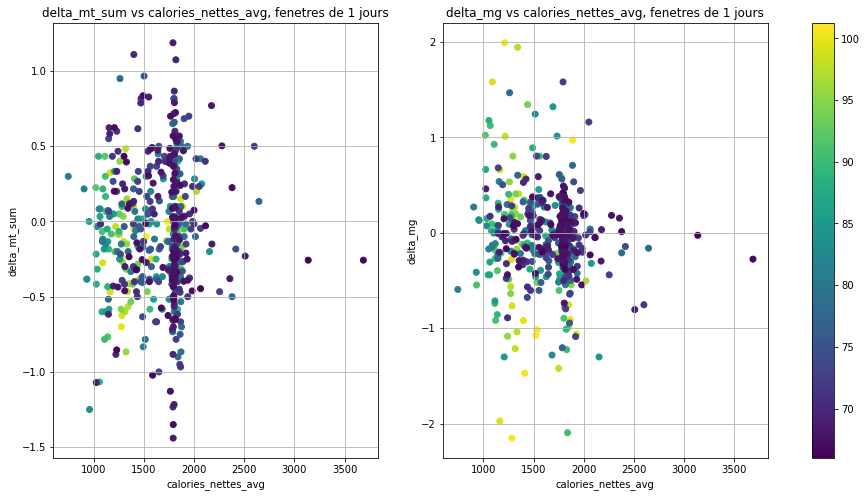

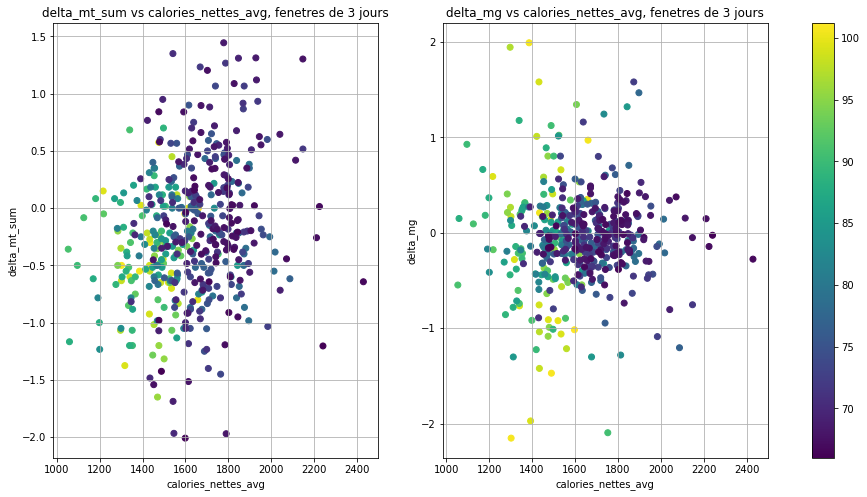

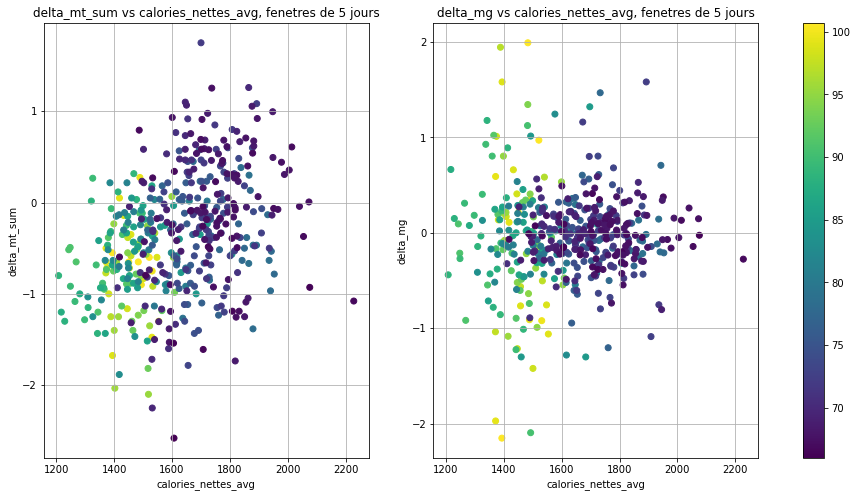

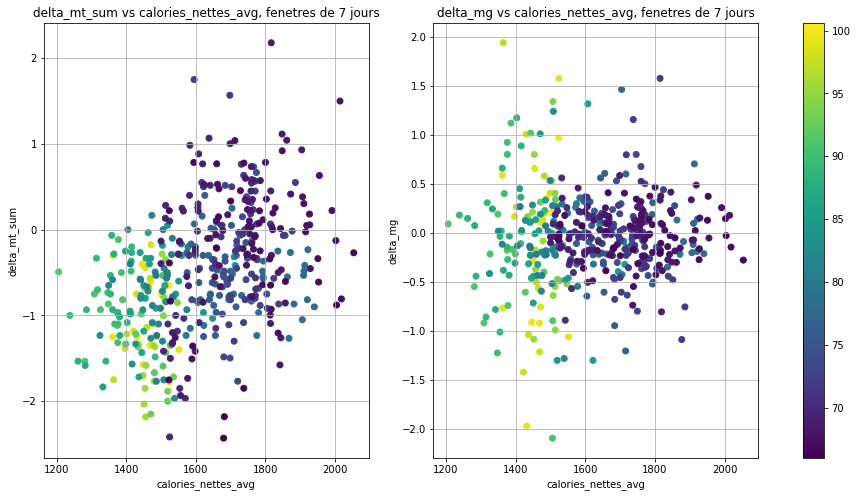

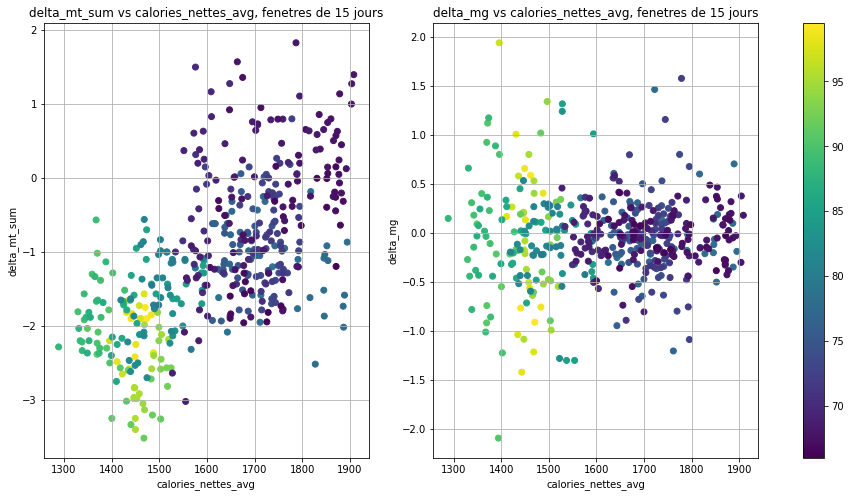

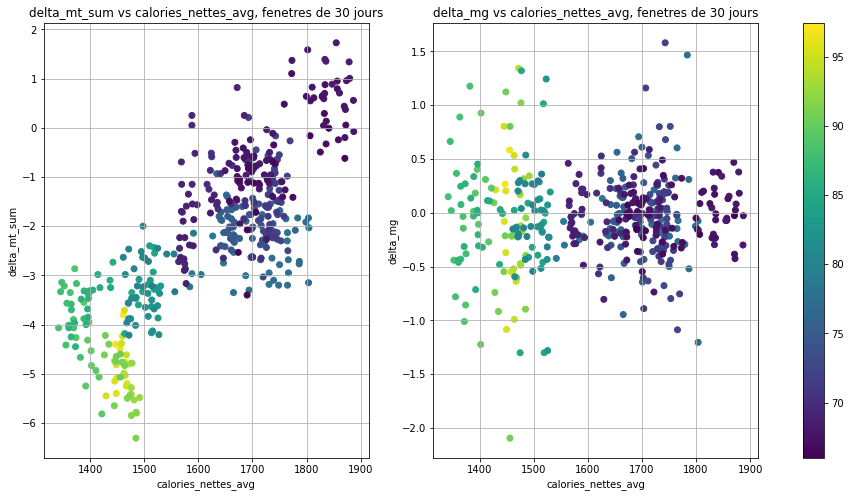

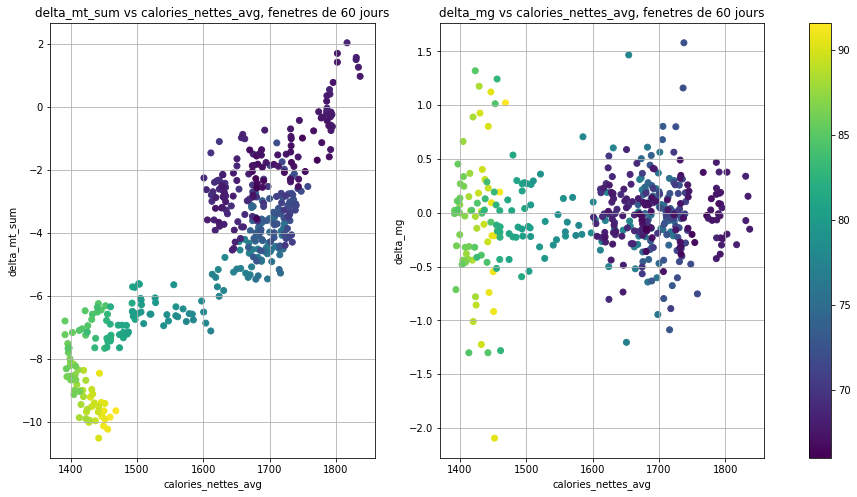

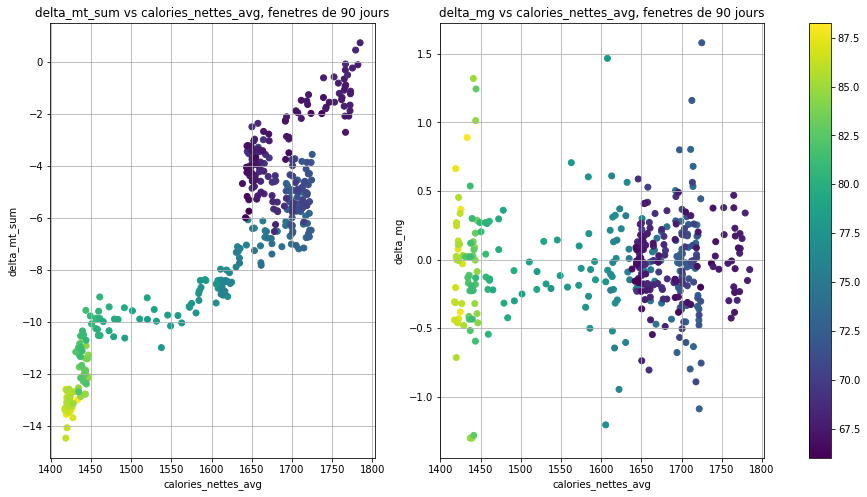

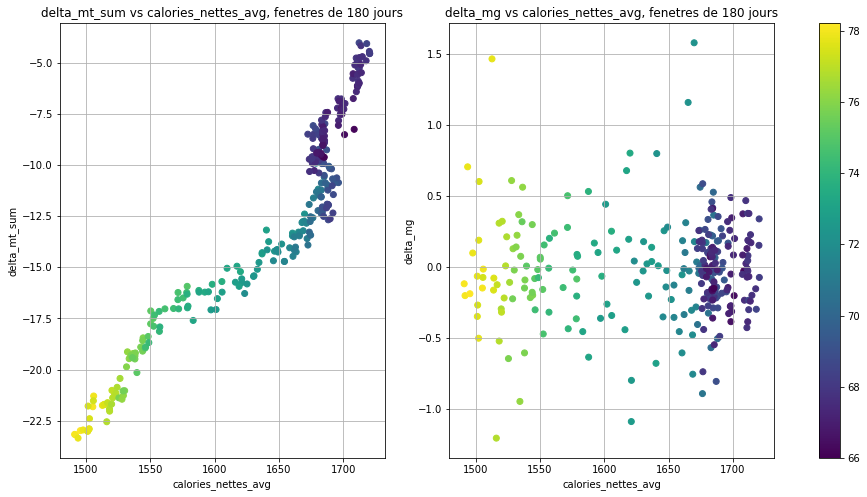

In [160]:
windows = [1,3,5,7,15,30,60,90,180]

for w in windows:
    window_length = w
    
    df2 = df.copy()

    df2['calories_nettes_avg'] = pd.DataFrame(df2['calories_nettes'].rolling(window_length).mean())
    df2['delta_mt_sum']=pd.DataFrame(df2['delta_mt'].rolling(window_length).sum())
    df2['delta_mg_sum']=pd.DataFrame(df2['delta_mg'].rolling(window_length).sum())
    
    df2.dropna(inplace=True)
    
    attributes = ['delta_mt', 'delta_mg_sum', 'calories_nettes_sum']
    # pd.plotting.scatter_matrix(df2[attributes], figsize=(16,16))
    plt.show()
    
    custom_scatter(df2, 'calories_nettes_avg', 'delta_mt_sum', 'delta_mg', window_length=window_length)